In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from importlib import reload
from cycler import cycler
from itertools import chain

# source modules and classes being developed 
from writhe_tools.writhe import (Writhe,
                                 to_writhe_matrix,
                                 calc_writhe_parallel,
                                 get_segments)


from writhe_tools.plots import (subplots_fes2d,
                                subplots_proj2d,
                                proj2d,
                                fes2d,
                                get_color_list,
                                box_plot)

from writhe_tools.tcca import CCA

from matplotlib.lines import Line2D

from writhe_tools.stats import Kmeans


from writhe_tools.md_tools import (ResidueDistances,
                                   get_residues,
                                   calc_rsa,
                                   calc_sa,
                                   traj_slice,
                                   load_traj,
                                   plot_distance_matrix,
                                   residue_distances,
                                   one_hot_residue_type,
                                   to_contacts
                                    )

from writhe_tools.utils import (lsdir,
                                group_by,
                                indices_stat,
                                sort_by_val_in,
                                reindex_list,
                                sort_indices_list,
                                load_array_dir,
                                filter_strs, 
                                contiguous_bool,
                                to_numpy,
                                one_hot,
                                num_str,
                                load_dict,
                                save_dict
                                )

from writhe_tools.msm_tools import MarkovModel

from writhe_tools.stats import pmf

import warnings
warnings.filterwarnings("ignore")


path = "/data/r1r2"
epi_dir = f"{path}/epi002"
apo_dir = f"{path}/apo"
cam_dir = f"{path}/cam1"
paths = [apo_dir, epi_dir, cam_dir]
labels = ['APO', 'EPI-002', '1aa']

[writhe_tools] ⏭️ Skipping 'graph_utils' (missing: torch_geometric)
[writhe_tools] 👉 To enable this module, install: pip install writhe-tools[graph]


In [2]:
protein_files = ['/data/r1r2/apo/protein.100us.dcd',
                 '/data/r1r2/epi002/protein.100us.dcd',
                 '/data/r1r2/cam1/protein.85us.dcd']


ligand_files = [lsdir(i, keyword=['dcd', 'ligand'], exclude=['wrap'], match=all)[0] for i in paths[1:]]
protein_pdb = '/data/r1r2/epi002/R2_dimer.pdb'
ligand_pdbs = [
               '/data/r1r2/epi002/R2_dimer.epi002.rename.pdb',
               '/data/r1r2/cam1/protein.ligand.pdb',
               ]
#atom_indices = md.load(protein_pdb).top.select('name CA')
dssp_paths = [lsdir(path, keyword=['dssp', 'npy'])[0] for path in paths]
r1r2_distance_paths = [lsdir(path, ['distance', 'r1r2', 'pkl'])[0] for path in paths]
residues, ca_index = get_residues(md.load(protein_pdb))
residues = residues[ca_index]
codes = np.array(list(md.load(protein_pdb).top.to_fasta()[0]))[:24]
#codes = np.array([f'{i}{j+1}' for j,i in enumerate(md.load(protein_pdb).top.to_fasta()[0])])[:24]

trunc = .3
pre_trunc = .3
state_width = .8
state_font_scale = 1.5


def get_longest_event(bools):
    idx = np.fromiter(map(len, event:=contiguous_bool(bools=bools)), float).argmax()
    return event[idx]


fes2d_args = dict(
      cmap="coolwarm",
      bins=55,
      n_contours=8,
      contour_lines=True,
      alpha_lines=0.35,
      alpha_contours=0.6,
      mask=False,
      scatter=True,
      scatter_alpha = .15,
      scatter_size=.05,
      scatter_stride=50,
      scatter_max=.35,
      scatter_min=.15,
      scatter_cmap="coolwarm",
      hide_ax=False,
      extend_border=0.1,
    )

# Simultaneous interactions

####  Generalizes the idea of taking the sum over 'dual contacts' - analyitically speaking, we're simply computing the joint disribution over a set of binary observables - integration gives the 'likelihood' or cumulative joint (simultaneous interactions at each frame). 

#### This is not ad hoc! However, it's worth noting that computing the full distribution is computationally infeasible but thanks to some identities of the kronocker product, the sum over each frame is very cheap

In [3]:
from writhe_tools.plots import get_extrema
from functools import reduce
from functools import partial

split = partial(np.array_split, indices_or_sections=2, axis=-1) 

def prod(vectors, sum_=False):
    if sum_:
        vectors = [v.sum(axis=-1) for v in vectors]
    return reduce(np.multiply, vectors)

In [4]:
ligand_helix = [prod(chain(*[split(np.load(f'{path}/dsspH.npy')),
                          split(to_contacts(np.load(f'{path}/ligand_distances.npy'))),]),
                          sum_=True) for path in paths]
mn, mx = get_extrema(np.concatenate(ligand_helix))
ligand_helix = [i / mx for i in ligand_helix]
ligand_helix = [i.clip(0, .55) / .55 for i in ligand_helix]


protein_ligand_helix = [prod(list(chain(*[split(np.load(f'{path}/dsspH.npy')),
                       split(to_contacts(np.load(f'{path}/ligand_distances.npy')))]))
                    +  [ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts()], sum_=True)
                       for path in paths]

mn, mx = get_extrema(np.concatenate(protein_ligand_helix))
protein_ligand_helix = [i / mx for i in protein_ligand_helix]
protein_ligand_helix = [i.clip(0, .55) / .55 for i in protein_ligand_helix]


protein_ligand = [prod(split(to_contacts(np.load(f'{path}/ligand_distances.npy')))
                    + [ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts()]
                          , sum_=True)
                 for path in paths]

mn, mx = get_extrema(np.concatenate(protein_ligand))
protein_ligand = [i / mx for i in protein_ligand]
protein_ligand = [i.clip(0, .55) / .55 for i in protein_ligand]

# Writhe tCCA Analysis and clustering

In [7]:
# load in precomputed projections
projs = [np.load(lsdir(path, keyword='writhe_tcca_lag_')[0])[1:] for path in paths]

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, maximum_filter
from sklearn.metrics import pairwise_distances_argmin
from numpy.random import default_rng

from typing import Tuple, Optional, Union
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter
from sklearn.metrics import pairwise_distances_argmin
import matplotlib.pyplot as plt



def density_peak_clustering(
    x: np.ndarray,
    y: np.ndarray,
    bins: Union[int, Tuple[int, int]] = 100,
    smoothing_sigma: float = 1.0,
    threshold_rel: float = 0.1,
    min_distance: int = 1,
    top_n_peaks: Optional[int] = None,
    plot_peaks: bool = False
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Cluster (x, y) data by identifying density peaks from a 2D histogram and using them as fixed centroids.

    Parameters:
        x, y: Input coordinates of shape (n,)
        bins: Number of histogram bins (int or tuple of (xbins, ybins))
        smoothing_sigma: Standard deviation for Gaussian smoothing
        threshold_rel: Relative threshold (0–1) to filter weak peaks
        min_distance: Minimum distance (in bins) between detected peaks
        top_n_peaks: If given, only keep the top N density peaks
        plot_peaks: Whether to plot smoothed density with detected peaks

    Returns:
        labels: Cluster labels for each (x, y) point (shape (n,))
        peak_coords: Coordinates of the peak centroids (shape (k, 2))
    """
    # Histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=bins)
    H_smooth = gaussian_filter(H, sigma=smoothing_sigma)

    # Local maxima detection
    local_max = H_smooth == maximum_filter(H_smooth, size=2 * min_distance + 1)
    threshold = H_smooth.max() * threshold_rel
    peak_mask = local_max & (H_smooth > threshold)
    peak_indices = np.argwhere(peak_mask)

    if peak_indices.shape[0] == 0:
        raise ValueError("No peaks found: try lowering threshold_rel or smoothing_sigma")

    # Convert indices to coordinates
    x_centers = 0.5 * (xedges[:-1] + xedges[1:])
    y_centers = 0.5 * (yedges[:-1] + yedges[1:])
    peak_coords = np.column_stack([x_centers[peak_indices[:, 0]], y_centers[peak_indices[:, 1]]])

    # Optionally select top-N peaks
    if top_n_peaks is not None and top_n_peaks < len(peak_coords):
        densities = H_smooth[peak_indices[:, 0], peak_indices[:, 1]]
        top_idxs = np.argsort(densities)[-top_n_peaks:]
        peak_coords = peak_coords[top_idxs]

    # Assign points to nearest peak
    data_points = np.column_stack([x, y])
    labels = pairwise_distances_argmin(data_points, peak_coords)

    # Optional plot of smoothed density and peaks
    if plot_peaks:
        plt.figure(figsize=(4, 4))
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        plt.imshow(H_smooth.T, origin='lower', extent=extent, aspect='auto', cmap='magma')
        plt.scatter(peak_coords[:, 0], peak_coords[:, 1], c='cyan', s=80, marker='x', label='Density Peaks')
        plt.title("Smoothed 2D Histogram with Density Peaks")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return labels, peak_coords


from typing import Union, Sequence
import numpy as np

def merge_cluster_labels(
    labels: np.ndarray,
    to_merge: Union[Sequence[int], np.ndarray]
) -> np.ndarray:
    """save_dict
    Merge specified cluster labels into a single cluster and reindex the labels to be contiguous from 0.

    Parameters:
        labels: Array of original cluster labels (shape (n,))
        to_merge: Sequence of label values to merge into one cluster

    Returns:
        new_labels: New array of labels with merged clusters and contiguous relabeling
    """
    labels = np.asarray(labels)
    to_merge = set(to_merge)

    # Pick the smallest label in to_merge to represent the merged cluster
    merge_target = min(to_merge)

    # Step 1: Apply merge
    merged = labels.copy()
    merged[np.isin(merged, list(to_merge))] = merge_target

    # Step 2: Reindex to contiguous integers starting at 0
    unique = np.unique(merged)
    remap = {old: new for new, old in enumerate(unique)}
    new_labels = np.vectorize(remap.get)(merged)

    return new_labels

# APO : Writhe tCCA Density Based clustering

In [274]:
dtrajs = []

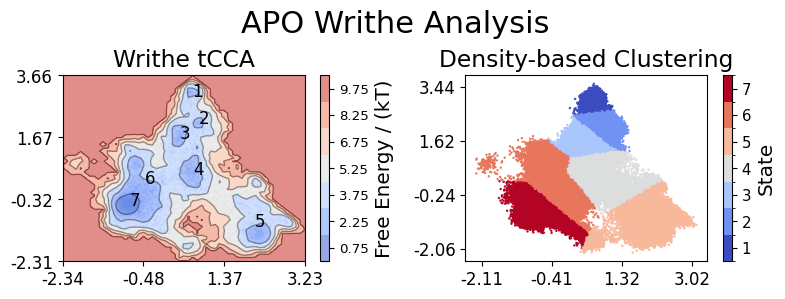

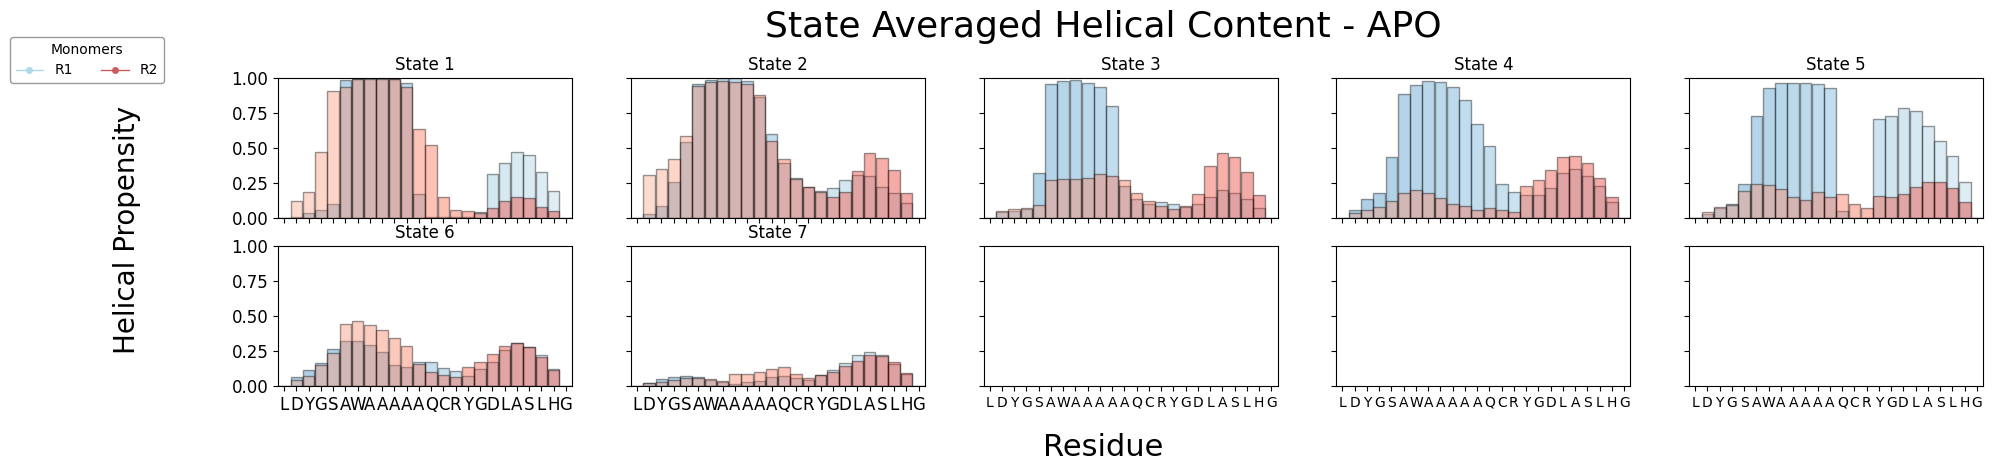

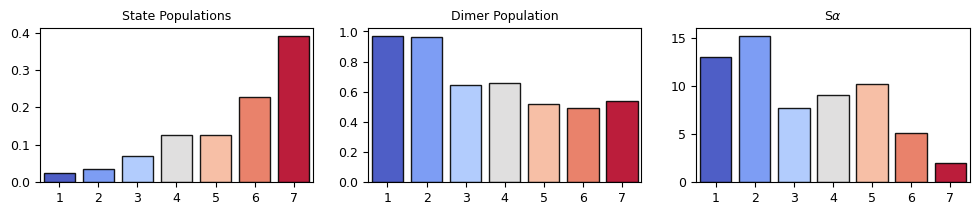

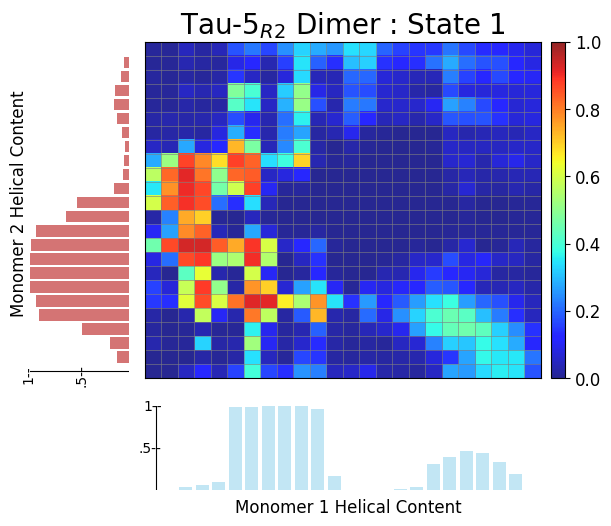

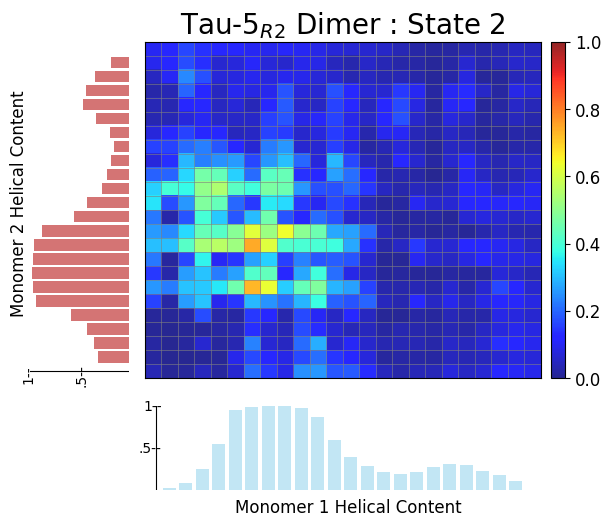

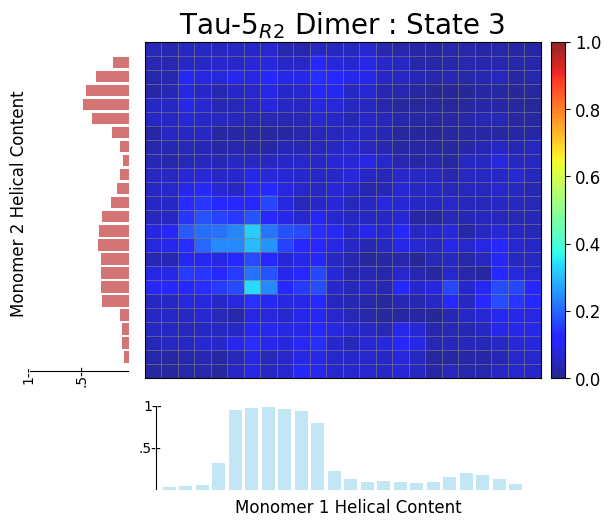

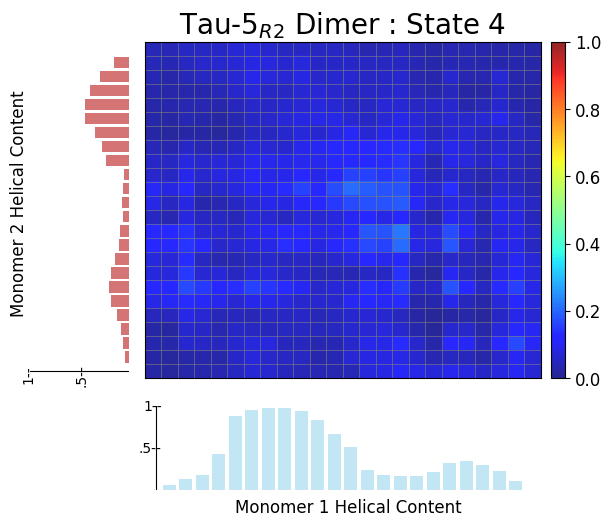

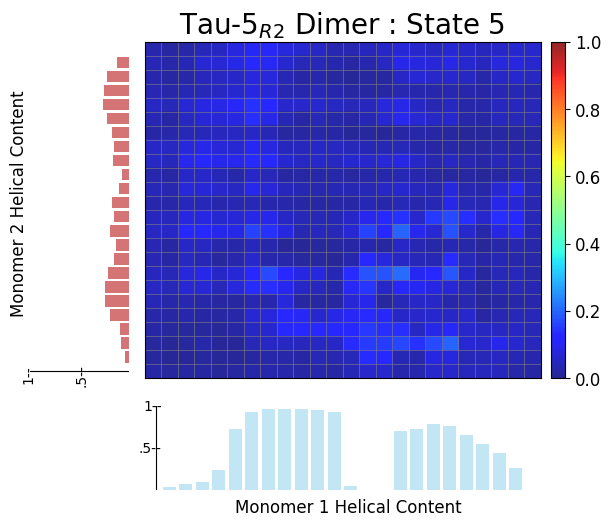

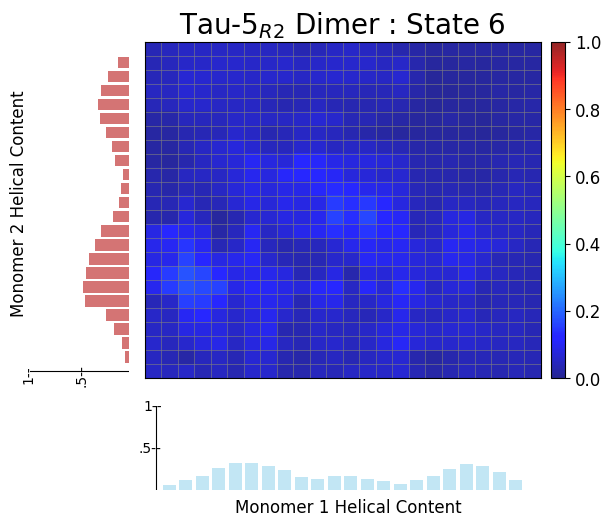

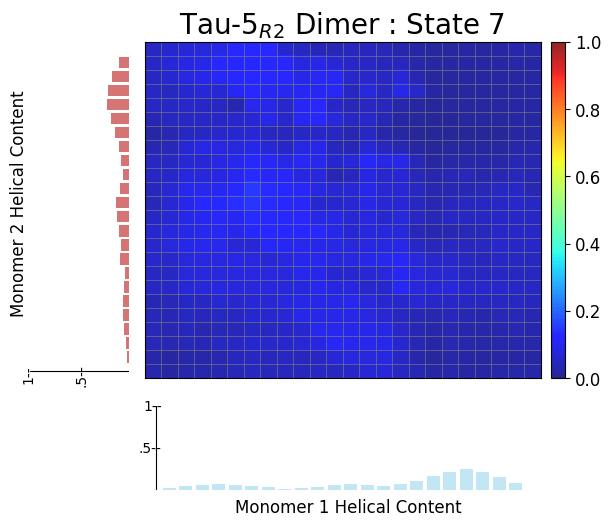

In [328]:
dtraj, centroids = density_peak_clustering(x = projs[0].T[0],
                                            y=projs[0].T[1],
                                            smoothing_sigma=1.3,
                                            threshold_rel=.05
                                           )
dtraj = merge_cluster_labels(dtraj, [1, 2])
reindex = np.array([7, 6, 3, 4, 1, 2, 5]) - 1
dtraj = reindex[dtraj]
centroids = group_by(dtraj, projs[0], partial(np.mean, axis=0))
frames_cl = group_by(dtraj)

fig, ax = plt.subplots(1, 2, figsize=(8, 2.7))
fes2d(projs[0][:, :2], cluster_centers=centroids, ax=ax[0],
      **fes2d_args, title='Writhe tCCA', font_scale=1.2)
proj2d(projs[0][:, :2], c=dtraj, state_map=True, ax=ax[1],
       cmap='coolwarm', title = 'Density-based Clustering', font_scale=1.2)
fig.tight_layout()
fig.suptitle("APO Writhe Analysis", y=1.09, size=22)


helix = np.load(f'{paths[0]}/dsspH.npy')

fig, axes = plt.subplots(2, 5, figsize=(22, 4), sharex=True, sharey=True)

for i, (ax, frames) in enumerate(zip(axes.flat, frames_cl)):
    
    box_plot(helix[frames][:, :24].mean(0), label_stride=1, cmap="Blues_r",
             ax=ax, alpha=.4, labels=codes,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(helix[frames][:, 24:].mean(0), label_stride=1, cmap="Reds",
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Population", 
             labels=codes, title = f"State {i+1}",
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=f"R{i+1}",
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, color in enumerate(["lightblue", "indianred"])]

fig.legend(handles=legend_elements,title="Monomers",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
           bbox_to_anchor = [0,1])

fig.supylabel("Helical Propensity", x=.05, size=20)
fig.supxlabel("Residue", x=.5, size=22, y=-0.08)
fig.suptitle("State Averaged Helical Content - APO", y= 1.05, size=26)

fig, ax = plt.subplots(1, 3, figsize=(12, 2))

box_plot(group_by(dtraj, reduction=lambda x : x.sum() / len(dtraj)),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(frames_cl) + 1),
         title = 'State Populations',
         rotation=0,
         trunc=0,
         width=state_width,
         pre_trunc=0,
         ymin=0,
         ax=ax[0])



box_plot(group_by(dtraj,ResidueDistances.load(f'{paths[0]}/r1r2_ca_distance_dict.pkl'
                                                ).contacts(0.6).any(1),
                           reduction=np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(frames_cl) +1),
         title = 'Dimer Population',
         rotation=0,
         trunc=0,
         pre_trunc=0,
         width=state_width,
         ax=ax[1])


box_plot(group_by(dtraj,
                np.load(f"{paths[0]}/r1r2_sa.npy").sum(-1),
                np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(frames_cl) +1),
         title = r'S$\alpha$',
         rotation=0,
         trunc=0,
         pre_trunc=0,
         width=state_width,
         ax=ax[2])


for i, frames in enumerate(frames_cl):
    build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[0]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, 
                                                                                                    cut_off=1)[frames].mean(0),
                              np.load(f'{paths[0]}/dsspH.npy', )[frames].mean(0)[:24],
                              np.load(f'{paths[0]}/dsspH.npy', )[frames].mean(0)[24:],
                              cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer : State {i+1}',
                              bottom_title='R2 Helical Content',vmin=0, vmax=1,
                              left_title='R1 Helical Content')

dtrajs.append(dtraj)

# EPI-002 : Writhe tCCA Density Based clustering

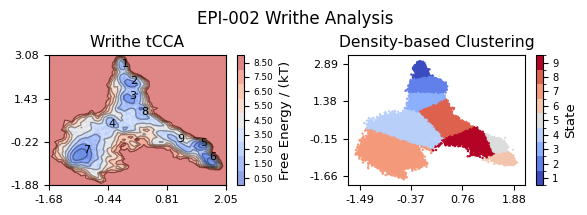

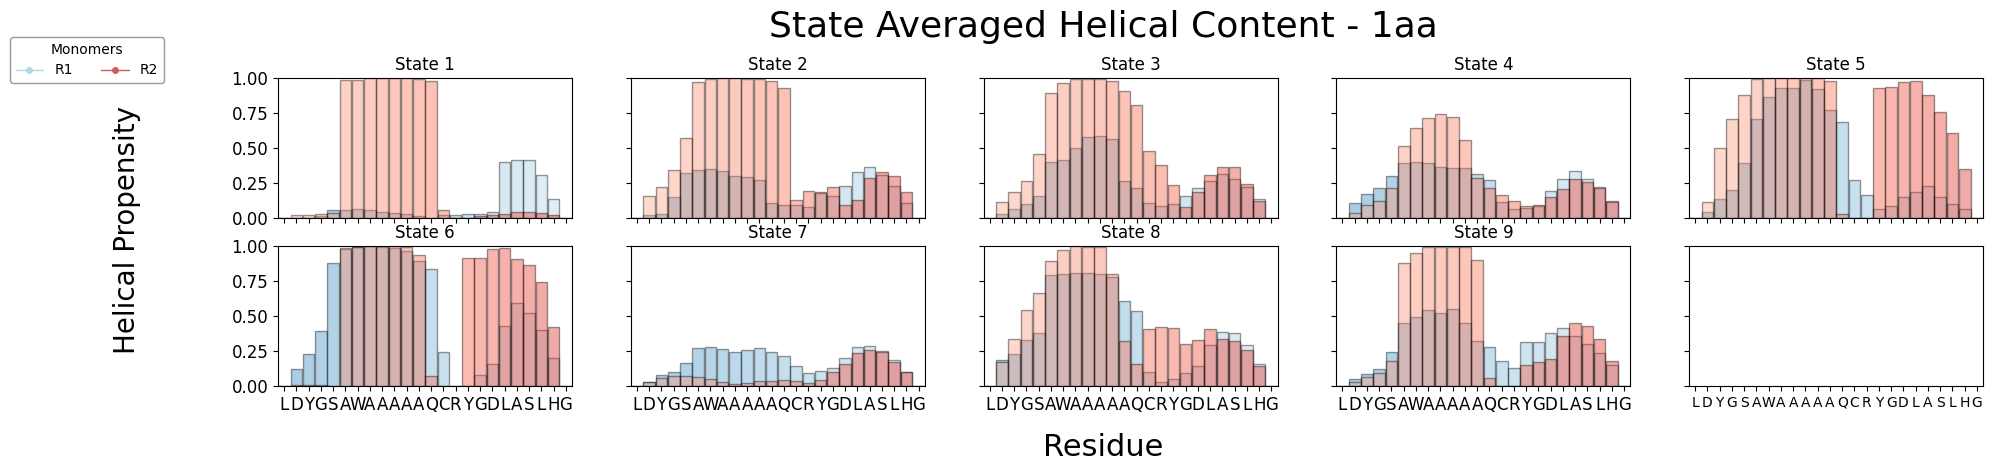

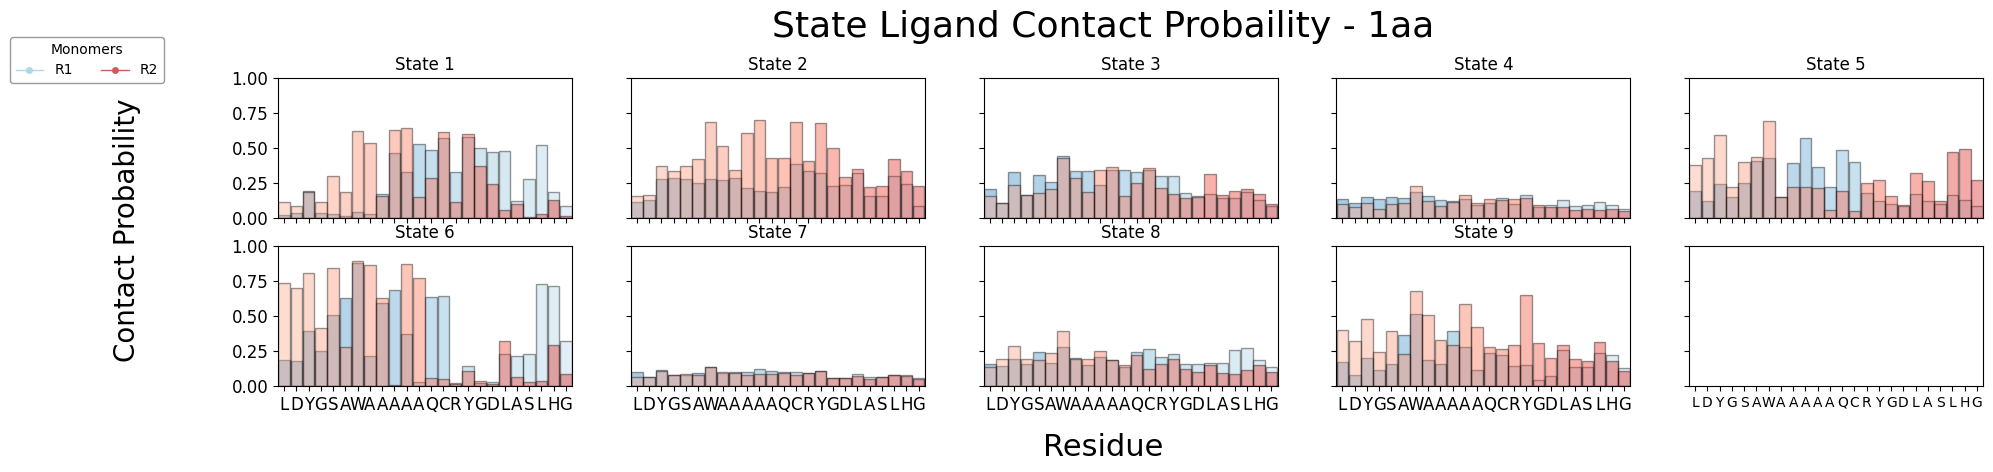

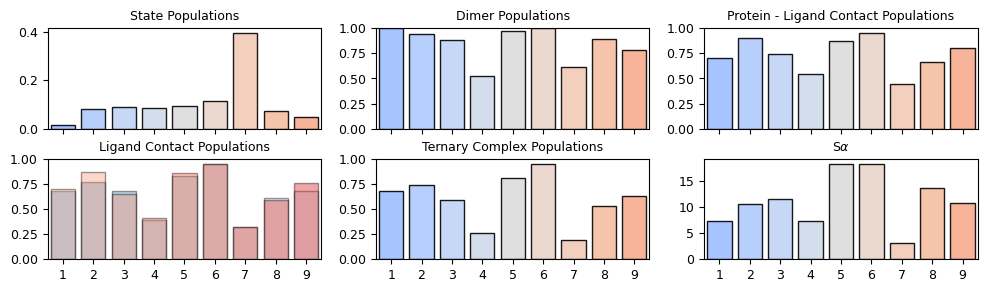

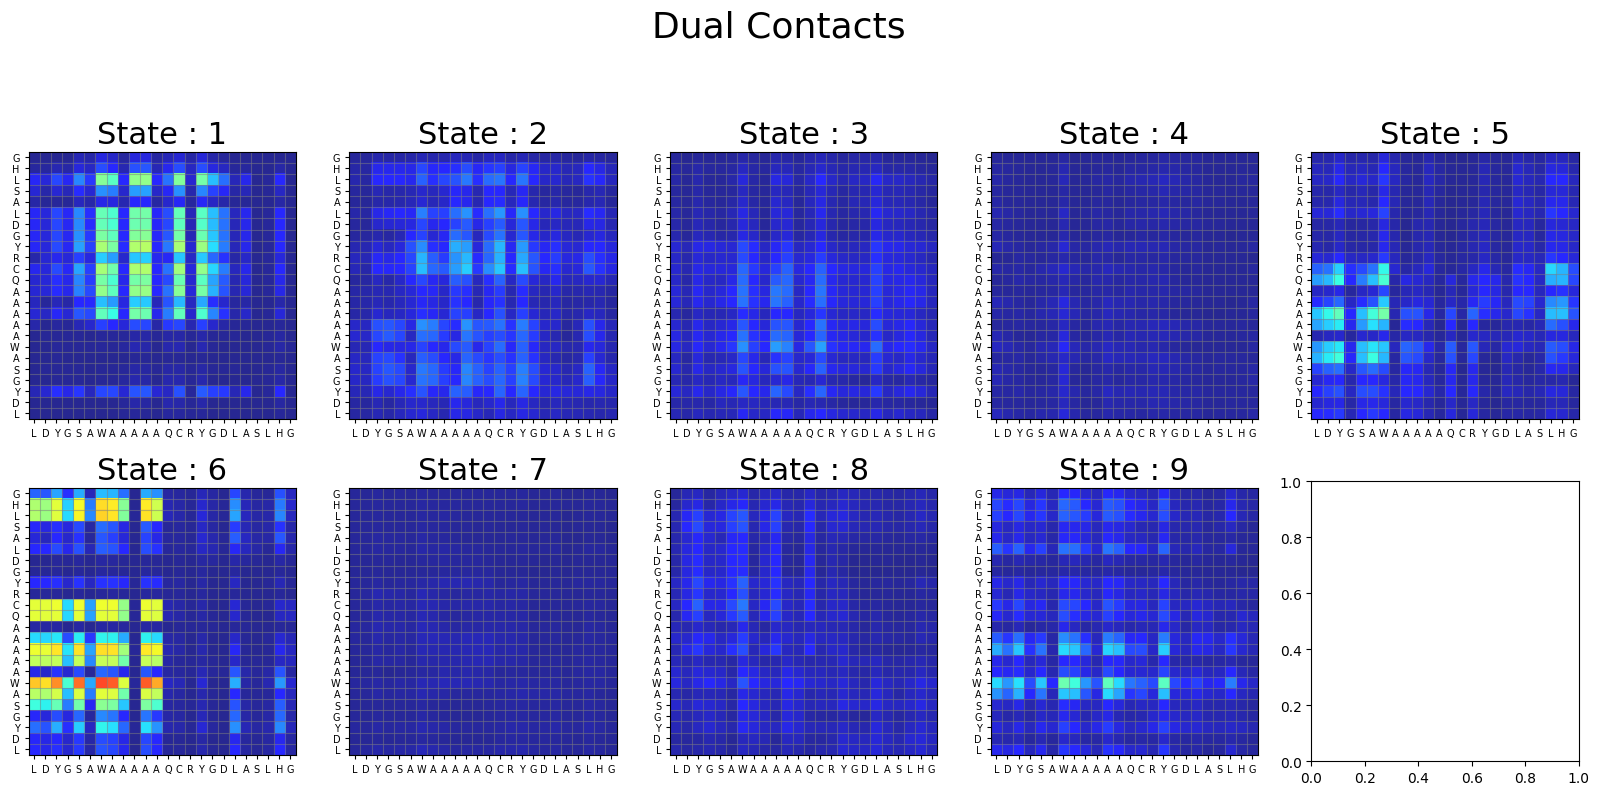

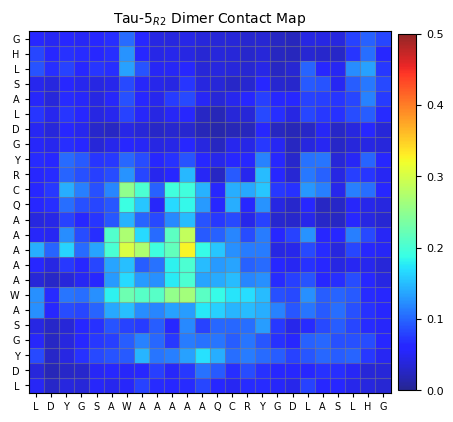

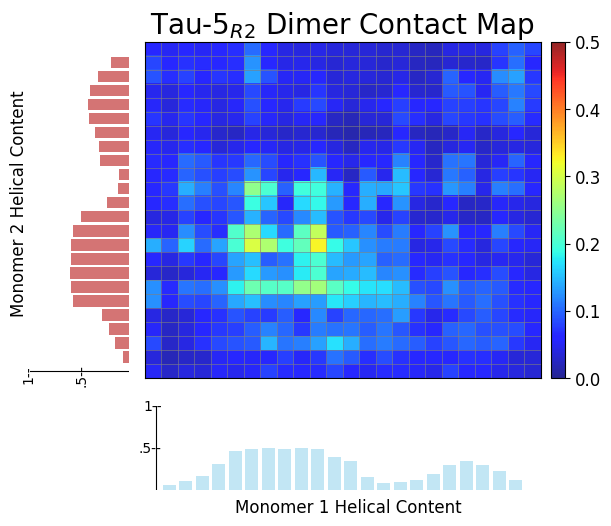

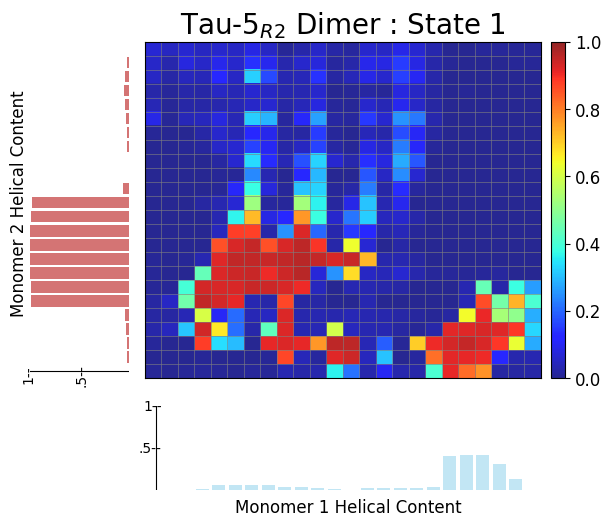

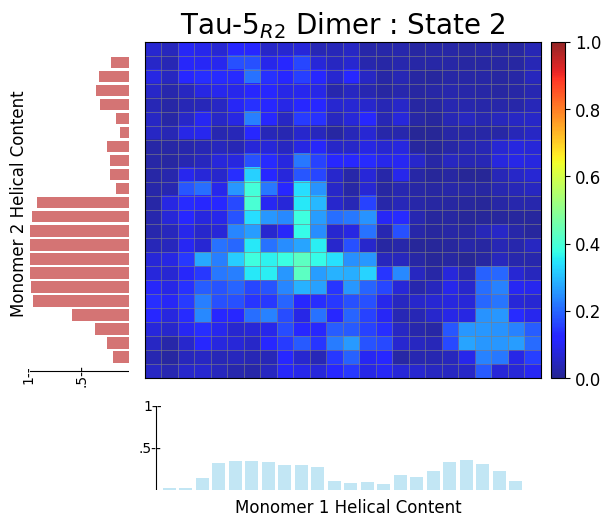

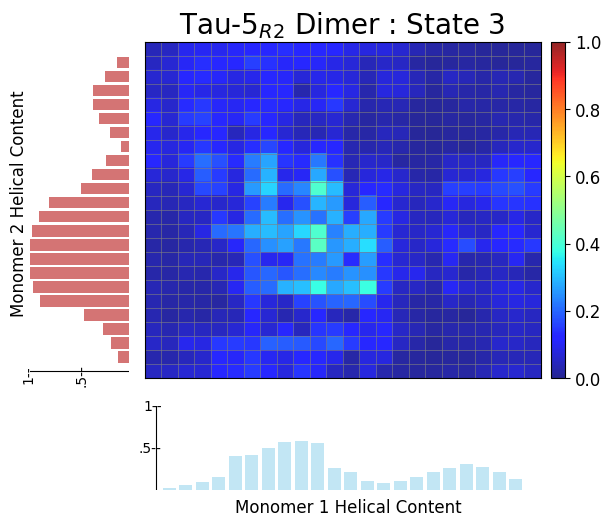

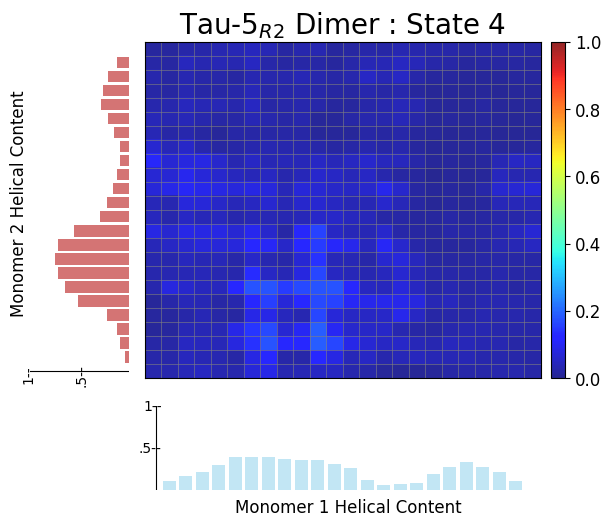

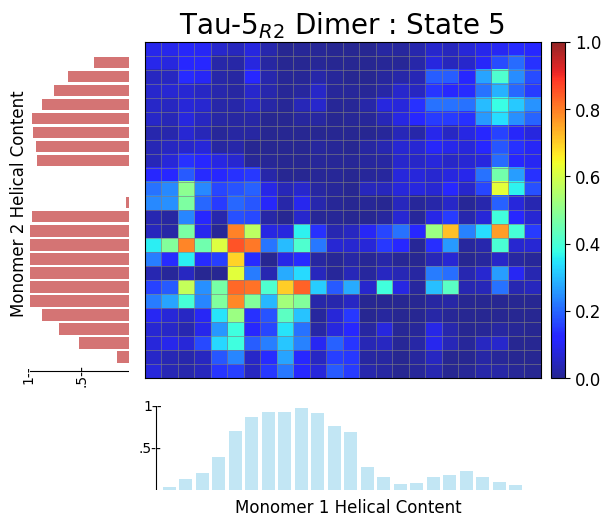

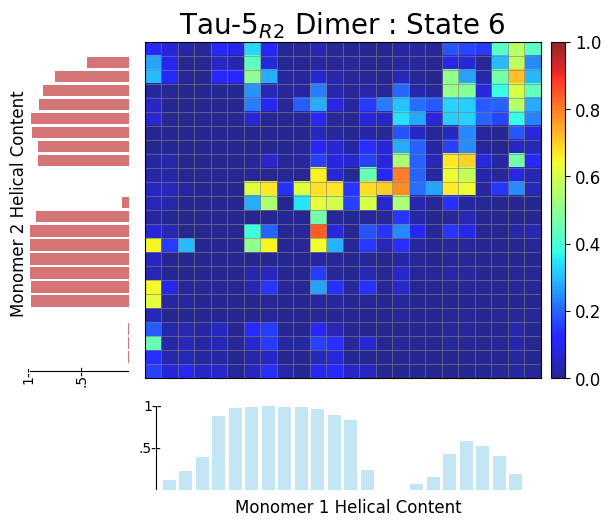

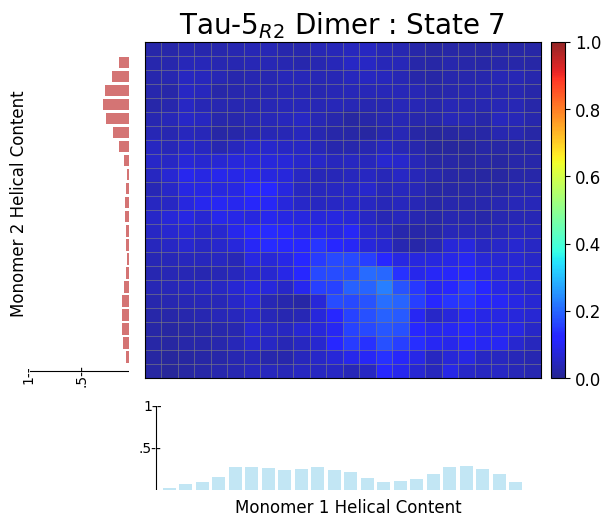

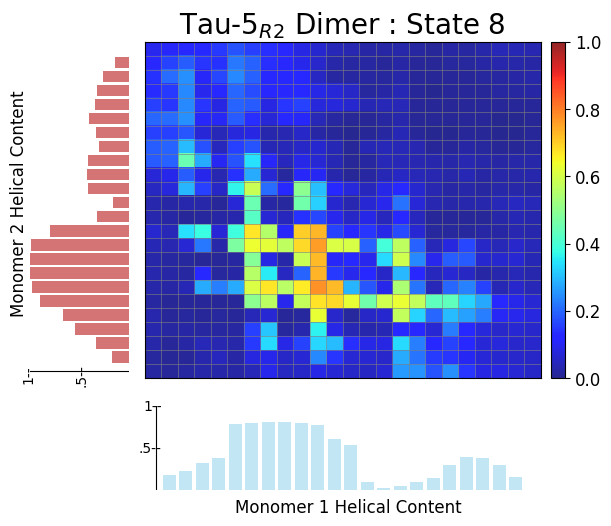

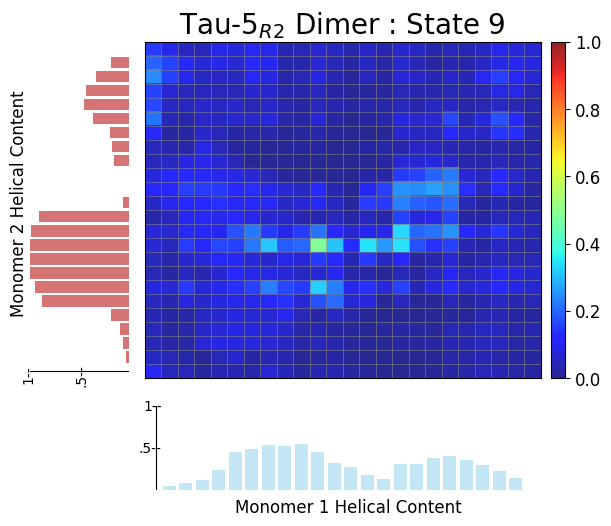

In [326]:
dtraj, centroids = density_peak_clustering(x = projs[1].T[0], y=projs[1].T[1])
dtraj = merge_cluster_labels(dtraj, [5, 6])
reindex = np.array([7, 4, 1, 3, 2, 8, 9, 5, 6]) - 1
dtraj = reindex[dtraj]
centroids = group_by(dtraj, projs[1], partial(np.mean, axis=0))
frames_cl = group_by(dtraj)

fig, ax = plt.subplots(1, 2, figsize=(6, 2))
fes2d(projs[1][:, :2], cluster_centers=centroids, ax=ax[0],
      title='Writhe tCCA', font_scale=.8, **fes2d_args)
proj2d(projs[1][:, :2], c=dtraj, state_map=True, ax=ax[1],
       cmap='coolwarm', title = 'Density-based Clustering', font_scale=.8)
fig.tight_layout()
fig.suptitle("EPI-002 Writhe Analysis", y=1.05)


helix = np.load(f'{paths[1]}/dsspH.npy')

fig, axes = plt.subplots(2, 5, figsize=(22, 4), sharex=True, sharey=True)

for i, (ax, frames) in enumerate(zip(axes.flat, frames_cl)):
    
    box_plot(helix[frames][:, :24].mean(0), label_stride=1, cmap="Blues_r",
             ax=ax, alpha=.4, labels=codes,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(helix[frames][:, 24:].mean(0), label_stride=1, cmap="Reds",
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Population", 
             labels=codes, title = f"State {i+1}",
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=f"R{i+1}",
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, color in enumerate(["lightblue", "indianred"])]

fig.legend(handles=legend_elements,title="Monomers",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
           bbox_to_anchor = [0,1])

fig.supylabel("Helical Propensity", x=.05, size=20)
fig.supxlabel("Residue", x=.5, size=22, y=-0.08)
fig.suptitle("State Averaged Helical Content - 1aa", y= 1.05, size=26)

contacts = to_contacts(np.load(f'{paths[1]}/ligand_distances.npy'), 0.6)


fig, axes = plt.subplots(2, 5, figsize=(22, 4), sharex=True, sharey=True)


for i, (ax, frames) in enumerate(zip(axes.flat, frames_cl)):
    
    box_plot(contacts[frames][:, :24].mean(0), label_stride=1, cmap="Blues_r",
             ax=ax, alpha=.4, labels=codes,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(contacts[frames][:, 24:].mean(0), label_stride=1, cmap="Reds",
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Population", 
             labels=codes, title = f"State {i+1}",
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=f"R{i+1}",
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, color in enumerate(["lightblue", "indianred"])]

fig.legend(handles=legend_elements,title="Monomers",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
           bbox_to_anchor = [0, 1])

fig.supylabel("Contact Probability", x=.05, size=20)
fig.supxlabel("Residue", x=.5, size=22, y=-0.08)
fig.suptitle("State Ligand Contact Probaility - 1aa", y= 1.05, size=26)

fig, axes = plt.subplots(2, 3, figsize=(12, 3), sharex=True, sharey=False)
plt.subplots_adjust(hspace=.3)


ax = axes.flat

#distances = ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl')

bound_fractions = group_by(dtraj,
                           ResidueDistances.load(f'{paths[1]}/r1r2_ca_distance_dict.pkl'
                                                ).contacts(1).any(1),
                           reduction=np.mean)

#print(distances.contacts(1).any(1).mean())


# 1
box_plot(group_by(dtraj, reduction=lambda x : x.sum() / len(contacts)),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) + 1),
         title = 'State Populations',
         rotation=0,
         trunc=trunc,
         width=state_width,
         pre_trunc=pre_trunc,
         ymin=0,
         ax=ax[0])


# 2
box_plot(bound_fractions,
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) + 1),
         title = 'Dimer Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[1])

# 2
box_plot(group_by(dtraj, contacts.any(1), np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Protein - Ligand Contact Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[2])

# 3
box_plot(group_by(dtraj, contacts[:, :24].any(1), np.mean),
         label_stride=1,
         cmap="Blues_r",
         alpha=.4, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) + 1),
         title = 'Ligand Contact Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[3])

# 4
box_plot(group_by(dtraj, contacts[:, 24:].any(1), np.mean),
         label_stride=1,
         cmap="Reds",
         alpha=.4, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Ligand Contact Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[3])

# 5
box_plot(group_by(dtraj, 
                  contacts[:, :24].any(1) * contacts[:, 24:].any(1),
                  np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Ternary Complex Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[4])

# 6
box_plot(group_by(dtraj,
                np.load(f"{paths[1]}/r1r2_sa.npy").sum(-1),
                np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = r'S$\alpha$',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         width=state_width,
         ax=ax[5])

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=False, sharey=False)
fig.suptitle("Dual Contacts", y= 1.05, size=26)
for k, (frames, ax) in enumerate(zip(frames_cl, axes.flat)):
    i, j = split(contacts[frames])
    plot_distance_matrix(i.T @ j / len(frames),
                         ax=ax,aspect='equal',
                         xticks=codes, yticks=codes,
                         vmax=1, vmin=0,
                         label_stride=1, grid=True,
                         grid_spacing=1, grid_color='gray',
                         alpha=.85, cbar=False)
    ax.set_title(f"State : {k+1}", size=22)



plot_distance_matrix(ResidueDistances.load(f'{paths[1]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, cut_off=1).mean(0),
                     aspect='equal', figsize=(5, 5) ,
                     xticks=codes,yticks=codes,
                     vmax=0.5,vmin=0,
                     label_stride=1,
                     grid=True,
                     grid_spacing=1,
                     grid_color='gray',
                     alpha=.85,
                     title=r'Tau-5$_{R2}$ Dimer Contact Map',
                    )



build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[1]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, cut_off=1).mean(0),
                          np.load(f'{paths[1]}/dsspH.npy', ).mean(0)[:24],
                          np.load(f'{paths[1]}/dsspH.npy', ).mean(0)[24:],
                          cmap='jet', title=r'Tau-5$_{R2}$ Dimer Contact Map',
                          bottom_title='R2 Helical Content',vmin=0, vmax=.5,
                          left_title='R1 Helical Content'
)

for i, frames in enumerate(frames_cl):
    build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[1]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, 
                                                                                                    cut_off=1)[frames].mean(0),
                              np.load(f'{paths[1]}/dsspH.npy', )[frames].mean(0)[:24],
                              np.load(f'{paths[1]}/dsspH.npy', )[frames].mean(0)[24:],
                              cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer : State {i+1}',
                              bottom_title='R2 Helical Content',vmin=0, vmax=1,
                              left_title='R1 Helical Content')
#fig.tight_layout()   

dtrajs.append(dtraj)

# 1aa : Writhe tCCA Density Based clustering

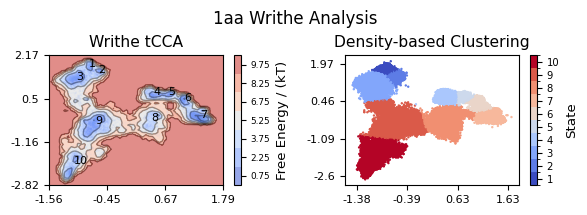

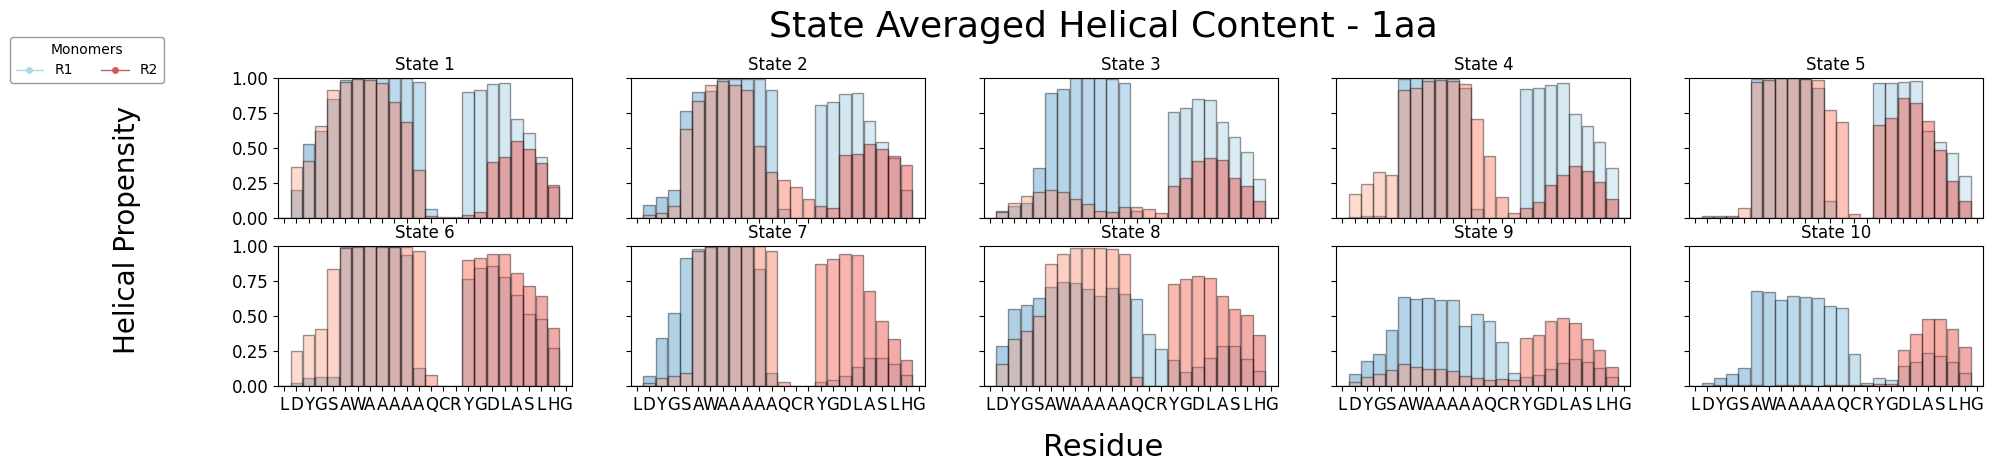

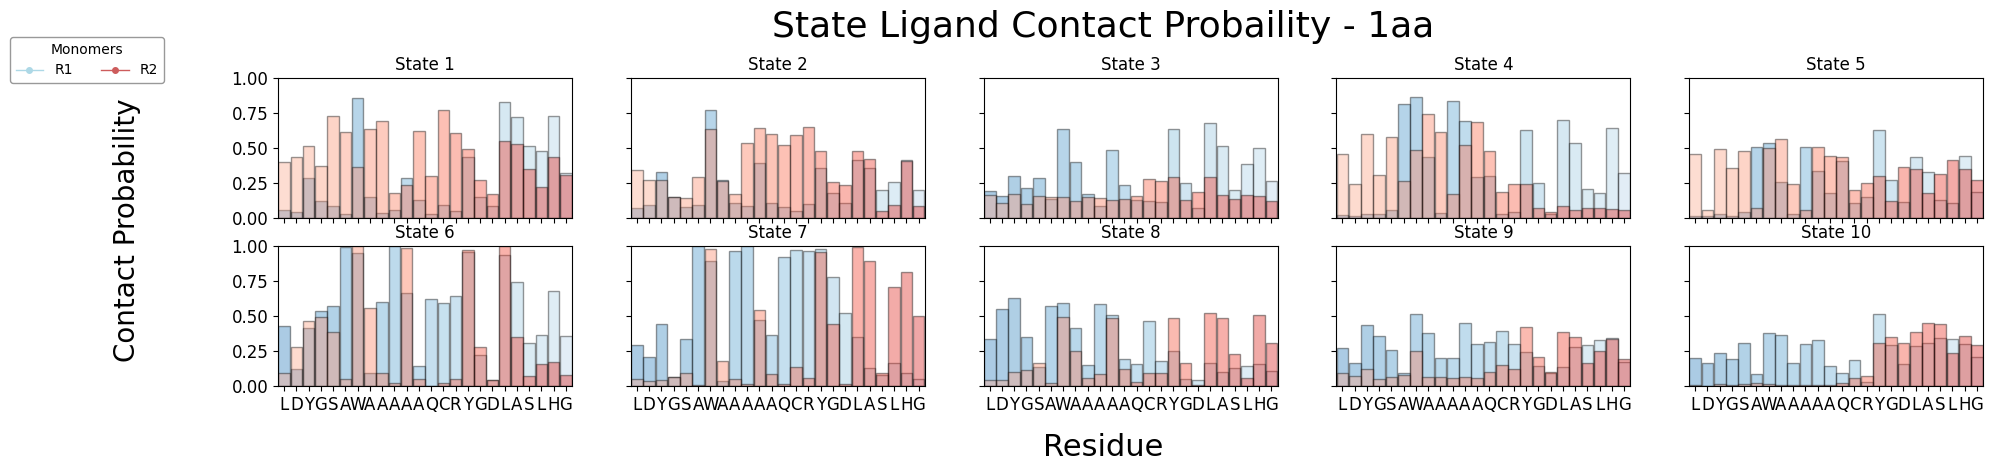

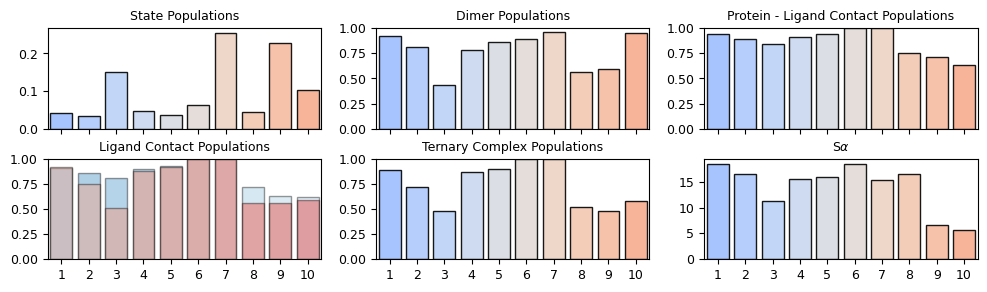

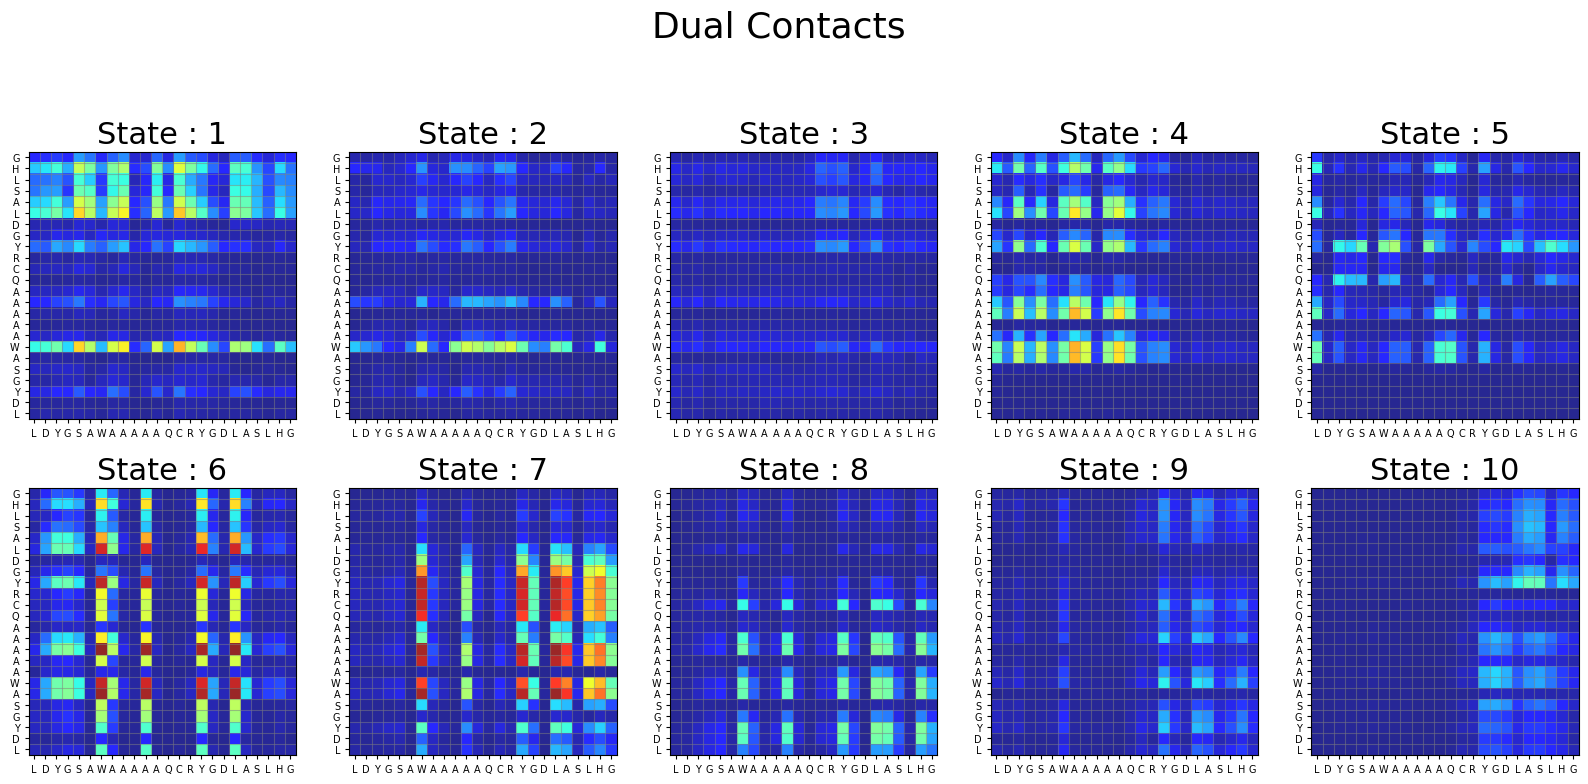

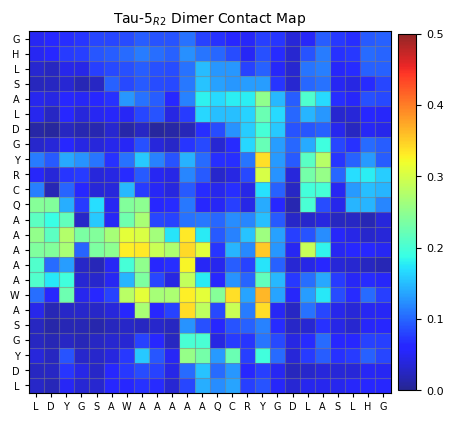

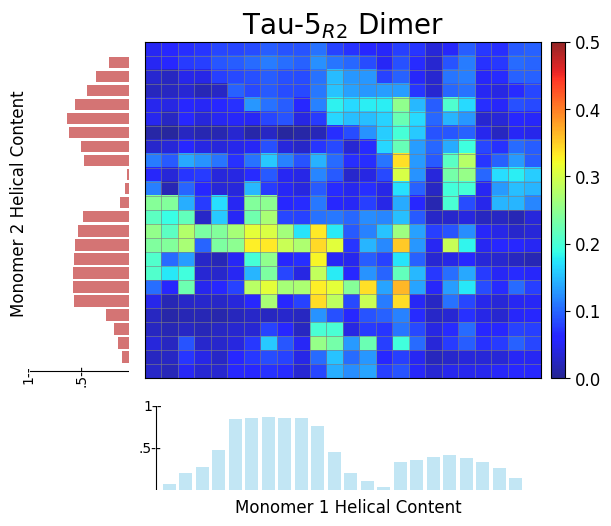

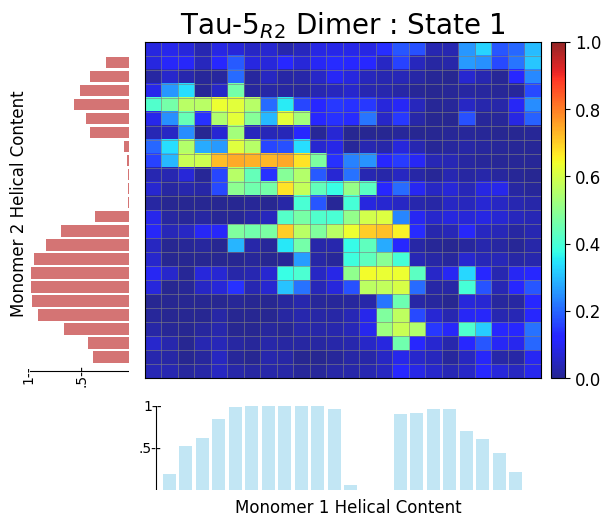

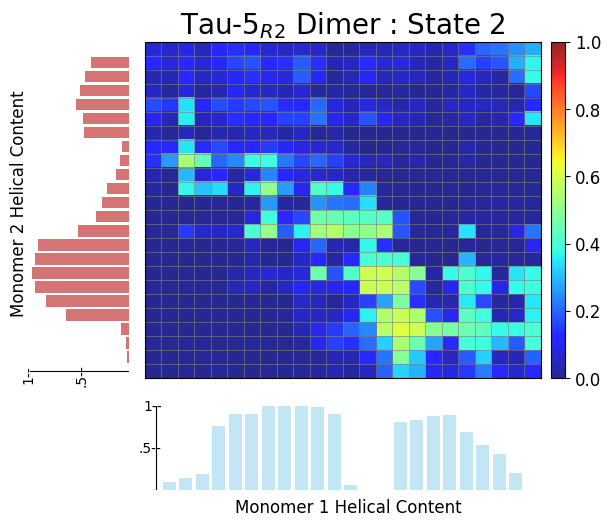

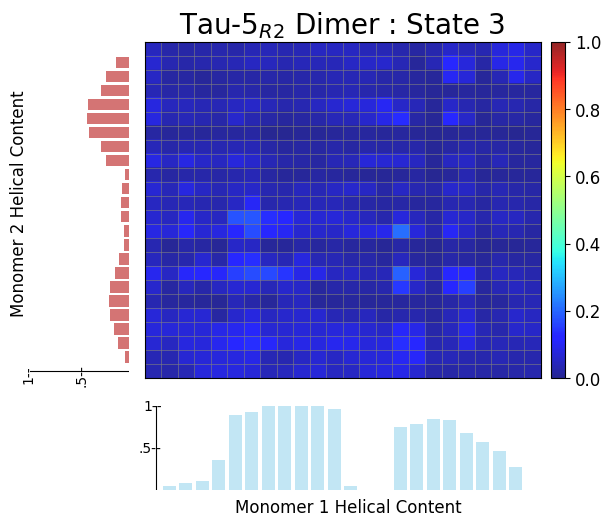

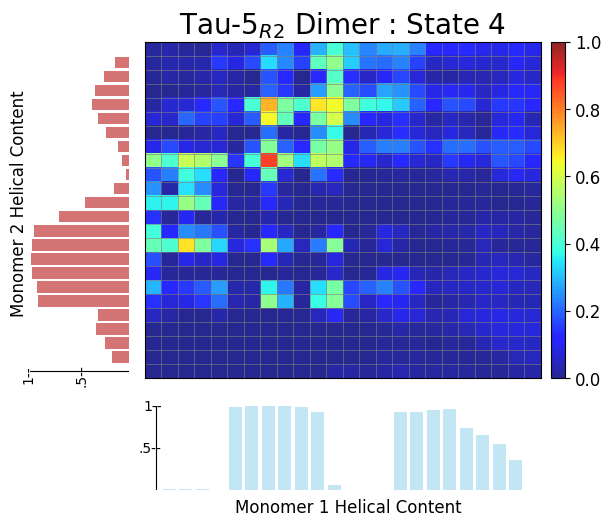

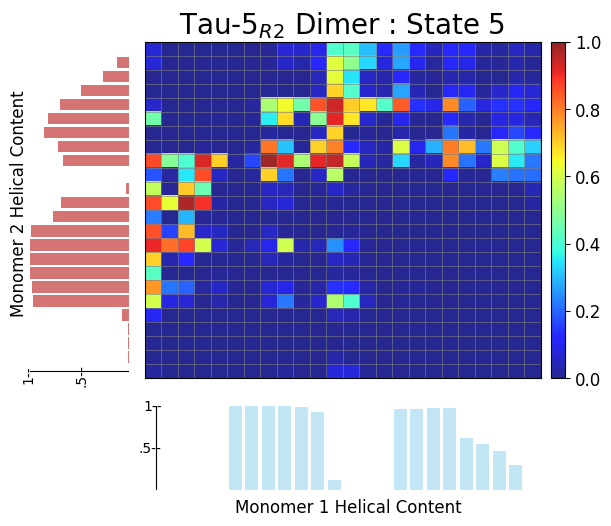

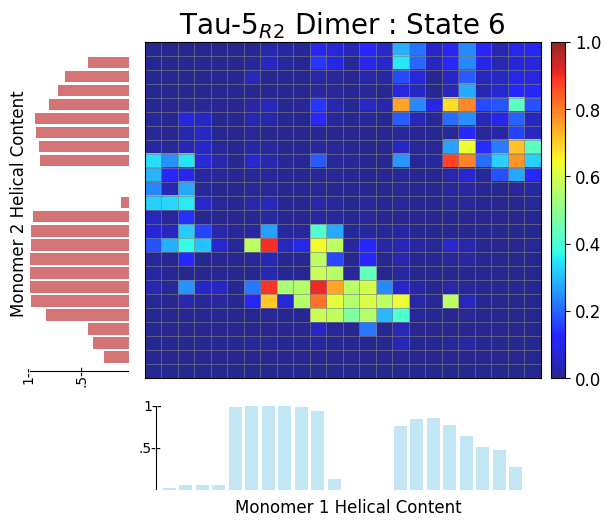

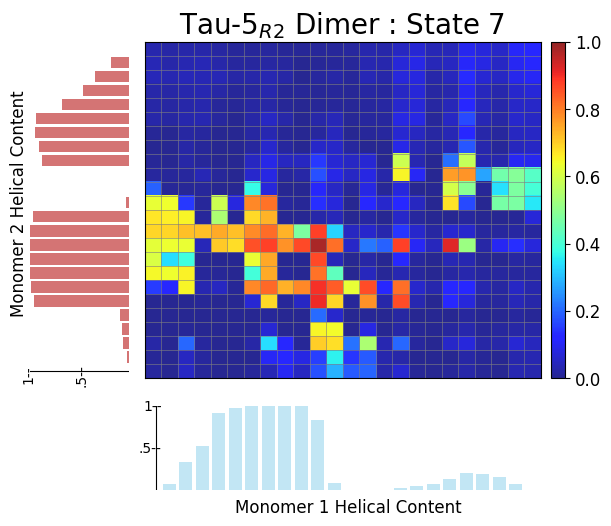

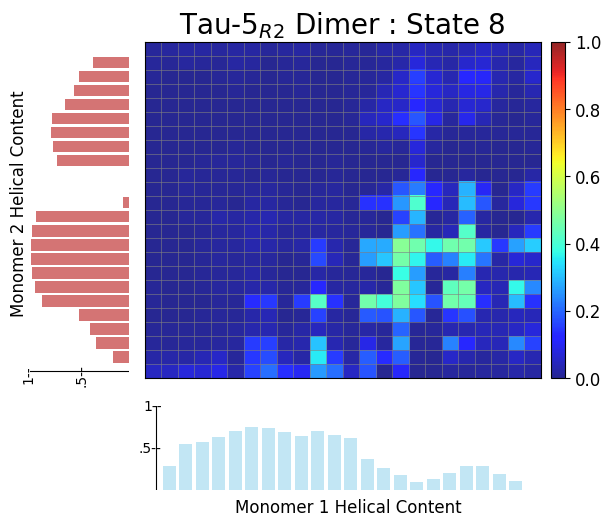

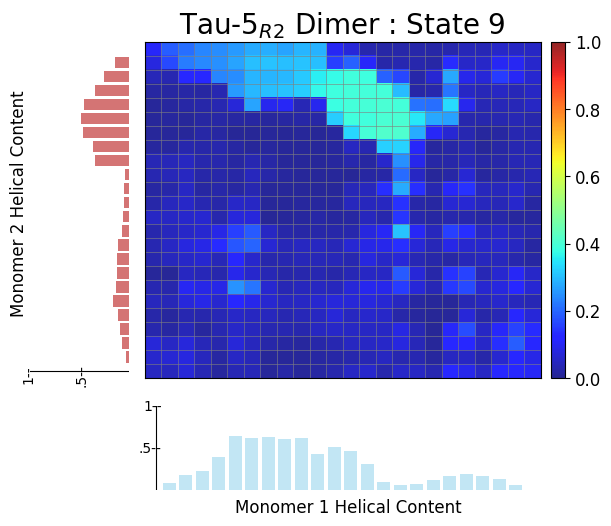

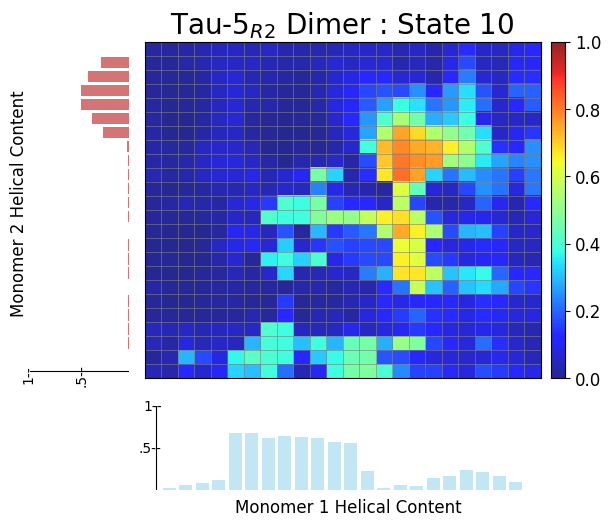

In [332]:
dtraj, centroids = density_peak_clustering(x = projs[2].T[0],
                                            y=projs[2].T[1],
                                            smoothing_sigma=1.3,
                                            threshold_rel=.05)

dtraj = merge_cluster_labels(dtraj, [1, 3])
dtraj = merge_cluster_labels(dtraj, [0, 2])
reindex = np.array([10, 3, 1, 9, 2, 4, 8, 5, 6, 7]) - 1
dtraj = reindex[dtraj]
centroids = group_by(dtraj, projs[2], partial(np.mean, axis=0))
frames_cl = group_by(dtraj)

fig, ax = plt.subplots(1, 2, figsize=(6, 2))
fes2d(projs[2][:, :2], cluster_centers=centroids, ax=ax[0],
      title='Writhe tCCA', font_scale=.8, **fes2d_args)
proj2d(projs[2][:, :2], c=dtraj, state_map=True, ax=ax[1],
       cmap='coolwarm', title = 'Density-based Clustering', font_scale=.8)
fig.tight_layout()
fig.suptitle("1aa Writhe Analysis", y=1.05)



helix = np.load(f'{paths[2]}/dsspH.npy')

fig, axes = plt.subplots(2, 5, figsize=(22, 4), sharex=True, sharey=True)

for i, (ax, frames) in enumerate(zip(axes.flat, frames_cl)):
    
    box_plot(helix[frames][:, :24].mean(0), label_stride=1, cmap="Blues_r",
             ax=ax, alpha=.4, labels=codes,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(helix[frames][:, 24:].mean(0), label_stride=1, cmap="Reds",
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Population", 
             labels=codes, title = f"State {i+1}",
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=f"R{i+1}",
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, color in enumerate(["lightblue", "indianred"])]

fig.legend(handles=legend_elements,title="Monomers",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
           bbox_to_anchor = [0,1])

fig.supylabel("Helical Propensity", x=.05, size=20)
fig.supxlabel("Residue", x=.5, size=22, y=-0.08)
fig.suptitle("State Averaged Helical Content - 1aa", y= 1.05, size=26)

contacts = to_contacts(np.load(f'{paths[2]}/ligand_distances.npy'), 0.6)


fig, axes = plt.subplots(2, 5, figsize=(22, 4), sharex=True, sharey=True)


for i, (ax, frames) in enumerate(zip(axes.flat, frames_cl)):
    
    box_plot(contacts[frames][:, :24].mean(0), label_stride=1, cmap="Blues_r",
             ax=ax, alpha=.4, labels=codes,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(contacts[frames][:, 24:].mean(0), label_stride=1, cmap="Reds",
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=codes, title = f"State {i+1}",
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=f"R{i+1}",
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, color in enumerate(["lightblue", "indianred"])]

fig.legend(handles=legend_elements,title="Monomers",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
           bbox_to_anchor = [0,1])

fig.supylabel("Contact Probability", x=.05, size=20)
fig.supxlabel("Residue", x=.5, size=22, y=-0.08)
fig.suptitle("State Ligand Contact Probaility - 1aa", y= 1.05, size=26)

fig, axes = plt.subplots(2, 3, figsize=(12, 3), sharex=True, sharey=False)
plt.subplots_adjust(hspace=.3)


ax = axes.flat

#distances = ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl')

bound_fractions = group_by(dtraj,
                           ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl'
                                                ).contacts(.6).any(1),
                           reduction=np.mean)

#print(distances.contacts(1).any(1).mean())



# 1
box_plot(group_by(dtraj, reduction=lambda x : x.sum() / len(contacts)),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) + 1),
         title = 'State Populations',
         rotation=0,
         trunc=trunc,
         width=state_width,
         pre_trunc=pre_trunc,
         ymin=0,
         ax=ax[0])


# 2
box_plot(bound_fractions,
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) + 1),
         title = 'Dimer Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[1])

# 2
box_plot(group_by(dtraj, contacts.any(1), np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Protein - Ligand Contact Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[2])

# 3
box_plot(group_by(dtraj, contacts[:, :24].any(1), np.mean),
         label_stride=1,
         cmap="Blues_r",
         alpha=.4, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Ligand Contact Populations',
         
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[3])

# 4
box_plot(group_by(dtraj, contacts[:, 24:].any(1), np.mean),
         label_stride=1,
         cmap="Reds",
         alpha=.4, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Ligand Contact Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[3])

# 5
box_plot(group_by(dtraj, 
                  contacts[:, :24].any(1) * contacts[:, 24:].any(1),
                  np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Ternary Complex Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[4])

# 6
box_plot(group_by(dtraj,
                np.load(f"{paths[2]}/r1r2_sa.npy").sum(-1),
                np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = r'S$\alpha$',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         width=state_width,
         ax=ax[5])

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=False, sharey=False)
fig.suptitle("Dual Contacts", y= 1.05, size=26)
for k, (frames, ax) in enumerate(zip(frames_cl, axes.flat)):
    i, j = split(contacts[frames])
    plot_distance_matrix(i.T @ j / len(frames),
                         ax=ax,aspect='equal',
                         xticks=codes, yticks=codes,
                         vmax=1, vmin=0,
                         label_stride=1, grid=True,
                         grid_spacing=1, grid_color='gray',
                         alpha=.85, cbar=False)
    ax.set_title(f"State : {k+1}", size=22)



plot_distance_matrix(ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, cut_off=1).mean(0),
                     aspect='equal', figsize=(5, 5) ,
                     xticks=codes,yticks=codes,
                     vmax=.5,vmin=0,
                     label_stride=1,
                     grid=True,
                     grid_spacing=1,
                     grid_color='gray',
                     alpha=.85,
                     title=r'Tau-5$_{R2}$ Dimer Contact Map',)

build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, cut_off=1).mean(0),
                          np.load(f'{paths[2]}/dsspH.npy', ).mean(0)[:24],
                          np.load(f'{paths[2]}/dsspH.npy', ).mean(0)[24:],
                          cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer',
                          bottom_title='R2 Helical Content',vmin=0, vmax=.5,
                          left_title='R1 Helical Content')

for i, frames in enumerate(frames_cl):
    build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, 
                                                                                                    cut_off=1)[frames].mean(0),
                              np.load(f'{paths[2]}/dsspH.npy', )[frames].mean(0)[:24],
                              np.load(f'{paths[2]}/dsspH.npy', )[frames].mean(0)[24:],
                              cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer : State {i+1}',
                              bottom_title='R2 Helical Content',vmin=0, vmax=1,
                              left_title='R1 Helical Content'
    )
#fig.tight_layout()   
dtrajs.append(dtraj)

In [648]:
from writhe_tools.plots import build_grid_plot, lineplot1D

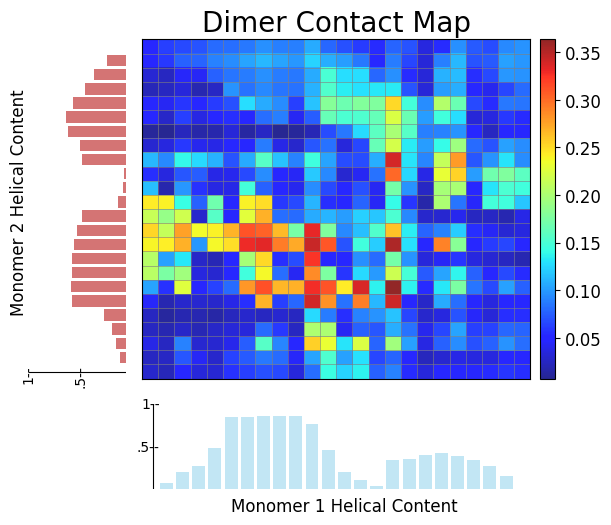

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

def build_matrix_boxplot_grid(matrix: np.ndarray,
                              bottom_values: np.ndarray,
                              left_values: np.ndarray,
                              title: str = None,
                              left_title: str = None,
                              bottom_title: str = None,
                              cmap: str = "viridis",
                              figsize: tuple = (6, 6),
                              wspace: float = 0.05,
                              hspace: float = 0.05,
                              width_ratios: tuple = (1, 4, 0.15),
                              height_ratios: tuple = (1, 4, 1),
                              vmin:float=None,
                              vmax:float=None,
                              cbar_label: str = None) -> None:
    
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig,
                             width_ratios=width_ratios,
                             height_ratios=height_ratios,
                             wspace=wspace, hspace=hspace)

   
    # Matrix plot
    ax_matrix = fig.add_subplot(spec[1, 1])
    im = ax_matrix.imshow(matrix, aspect='auto', cmap=cmap, alpha=.85,vmax=vmax, vmin=vmin )
    ax_matrix.tick_params(left=False, bottom=False,
                          labelleft=False, labelbottom=False)
    ax_matrix.invert_yaxis()
    ax_matrix.set_title(title, size=20)
    #ax_matrix.grid(True)

    nrows, ncols = matrix.shape
    ax_matrix.set_xticks(np.arange(ncols + 1) - 0.5, minor=True)
    ax_matrix.set_yticks(np.arange(nrows + 1) - 0.5, minor=True)
    ax_matrix.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.85)
    ax_matrix.tick_params(which='minor', bottom=False, left=False)
    
    # Left plot (horizontal bar)
    ax_left = fig.add_subplot(spec[1, 0], sharey=ax_matrix)
    ax_left.barh(np.arange(len(left_values)), left_values, color="indianred", alpha=.85)
    ax_left.set_xlim(0, 1)
    ax_left.axhline( 0, -1, color='black', ls='-', lw=0.8)
    ax_left.text(1.08, -0.18, '1--', va='center', ha='left', rotation=90)
    ax_left.text(.55, -0.3, '.5--', va='center', ha='left', rotation=90)

    ax_left.invert_xaxis()
    #ax_left.invert_yaxis()
    ax_left.axis("off")
    #ax_left.set_xlabel(left_title, size=22)
    
    # Colorbar
    cax = fig.add_subplot(spec[1, 2])
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=12)
    if cbar_label:
        cbar.set_label(cbar_label, rotation=-90, labelpad=10, size=25)

    # Bottom plot (vertical bar)
    ax_bottom = fig.add_subplot(spec[2, 1], sharex=ax_matrix)
    ax_bottom.bar(np.arange(len(bottom_values)), bottom_values, color="skyblue", alpha=.5, )
    ax_bottom.tick_params(top=False, bottom=False, labelbottom=False)
    #ax_bottom.set_title(bottom_title, size=22)
    #ax_bottom.set_yticks([])
    ax_bottom.axis("off")
    ax_bottom.set_xlabel('R2 Helical Contact')
    ax_bottom.set_ylim(0, 1)
    ax_bottom.axvline(.2, -1, color='black', ls='-', lw=0.8)
    ax_bottom.text(-.55, 1, '1--', va='center', ha='left', rotation=0)
    ax_bottom.text(-.845, 0.5, '.5--', va='center', ha='left', rotation=0)
        
    ax_bottom.text(5, -.2, 'Monomer 1 Helical Content', va='center', ha='left', rotation=0, size=12)
    ax_left.text(1.2, 12,  'Monomer 2 Helical Content', va='center', ha='left', rotation=90, size=12)


    plt.show()


# Show the plot
build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, cut_off=1).mean(0),
                          np.load(f'{paths[2]}/dsspH.npy', ).mean(0)[:24],
                          np.load(f'{paths[2]}/dsspH.npy', ).mean(0)[24:],
                          cmap='jet', title='Dimer Contact Map', bottom_title='R2 Helical Content',
                          left_title='R1 Helical Content'
)


In [136]:
import scipy
import numpy as np
from typing import Tuple

def bootstrap(data: np.ndarray,
              confidence_level: float = 0.68,
              n_resamples: int = 500,
              method: str = "percentile") -> Tuple[float, float]:
    """
    Bootstrap binary data to get the mean and an intentionally wide error estimate.

    Parameters:
        data: binary array of 0s and 1s
        confidence_level: typically 0.99 for wider intervals
        n_resamples: lower values increase variability (default 500)
        method: use 'percentile' to produce wider CIs

    Returns:
        mean: estimated mean of the binary array
        error: half-width of the confidence interval
    """

    res = scipy.stats.bootstrap((data,), statistic=np.mean,
                    confidence_level=confidence_level,
                    n_resamples=n_resamples,
                    method=method,
                    random_state=0)

    mean = np.mean(data)
    error = (res.confidence_interval.low, res.confidence_interval.high, ) 
    return [mean, error]


from pyblock.blocking import reblock, find_optimal_block
from collections import Counter
def block_error(x: np.ndarray):
    """
    x : (d, N) numpy array with d features and N measurements
    """
    n = x.shape[-1]
    blocks = reblock(x)
    optimal_indices = np.asarray(find_optimal_block(n, blocks))
    isnan = np.isnan(optimal_indices)
    #mode = Counter(optimal_indices[~isnan].astype(int)).most_common()[0][0]
    optimal_indices[isnan] = -1 # biggest block
    if x.ndim == 1:
        return x.mean(), blocks[optimal_indices[0]].std_err.item()
    else:
        return np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))])


Text(0.8, 0.82, '71.4%')

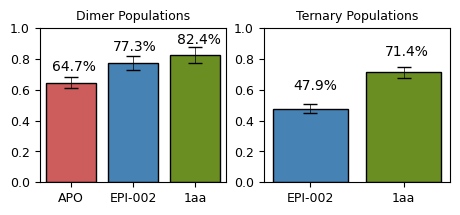

In [143]:
dimer_populations = np.array([block_error(ResidueDistances.load(f'{path}/r1r2_ca_distance_dict.pkl').contacts(1).any(1).astype(int))
                    for path in paths]).T


_, ax = plt.subplots(1, 2,
                     figsize=(5.3, 2), 
                     #dpi=500,
                    )
box_plot(dimer_populations[0],
         errors=dimer_populations[1],
         error_capsize=5,
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['indianred', 'steelblue', 'olivedrab'],
         alpha=1, 
         font_scale=state_font_scale, 
         labels=labels,
         title = 'Dimer Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=0.8,
         ax=ax[0])

ax[0].text(-.3, .72, f'{100 * dimer_populations[0,0] :.1f}%')
ax[0].text(.68, .85, f'{100 * dimer_populations[0,1] :.1f}%')
ax[0].text(1.7, .9, f'{100 * dimer_populations[0,2] :.1f}%')

ternary_populations = np.array([block_error(
    prod([i.any(1) for i in split(to_contacts(np.load(f'{path}/ligand_distances.npy'), 0.6))]))
                    for path in paths[1:]]).T



box_plot(ternary_populations[0],
         errors=ternary_populations[1],
         error_capsize=5,
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['steelblue', 'olivedrab'],
         alpha=1, 
         font_scale=state_font_scale, 
         labels=labels[1:],
         title = 'Ternary Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=0.8,
         ax=ax[1])

ax[1].text(-.18, .6, f'{100 * ternary_populations[0,0] :.1f}%')
ax[1].text(.8, .82, f'{100 * ternary_populations[0,1] :.1f}%')

In [139]:
def get_tau(x: np.ndarray) -> int:
    threshold = 1 / np.e
    below = np.where(x < threshold)[0]
    return below[0] if below.size > 0 else -1

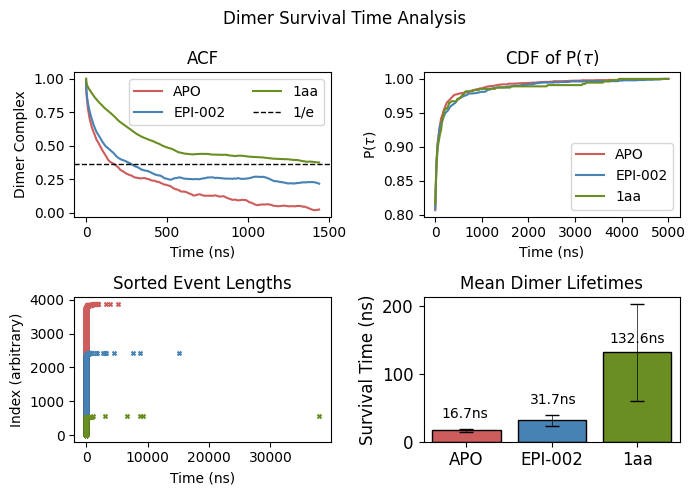

In [272]:
fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.flat
ax = axes
average_dimer = []
tau=[]
longest_dimer_event = []
lengths = []
for path, color, label in zip(paths,
                              ['indianred', 'steelblue', 'olivedrab'],
                             labels):
    
    # any residue - residue CA atom distance less than 1 nm 
    dimer = ResidueDistances.load(f'{path}/r1r2_ca_distance_dict.pkl').contacts(1).any(1).astype(int)

    #event lengths scaled
    lengths = 0.24 * np.fromiter(map(len, contiguous_bool(bools=dimer)), float)

    #bootstrap mean
    average_dimer.append(list(bootstrap(lengths, n_resamples=5000)))

    
    longest_dimer_event.append(get_longest_event(dimer))
    # have to bootstrap the lengths because it's not a time continuous measurement (block error doesn't make sense here)
    # inverse FFT for the ACF on binary array
    ac = acf(dimer)
    #get the correlation time
    tau.append(get_tau(ac))
    axes[0].plot(np.arange(0, 6000) * 0.24,  # scale the time
                 ac[:6000],
                 c=color,
                 label=label,
                )
    bins=200
    axes[1].plot( np.linspace(0, 5000, bins), np.cumsum(pmf(np.sort(lengths), bins=bins, range=(0,500))[0]), label=label, c=color)
    axes[2].scatter(np.sort(lengths), np.arange(len(lengths)), label=label, c=color, s=8, marker='x')
    #box_plot(pmf(np.sort(lengths), bins=4, range=(0,30000), norm=False)[0], label=label, ax=axes[2])



axes[2].set_xlabel('Time (ns)')
axes[2].set_ylabel('Index (arbitrary)')
axes[2].set_title('Sorted Event Lengths')

axes[1].set_ylabel(r'P($\tau$)')
axes[1].set_xlabel('Time (ns)')
axes[1].legend()
axes[1].set_title('CDF of ' + r'P($\tau$)')

axes[0].axhline(y=1/np.exp(1),
                linestyle='--',
                color='black',
                linewidth=1,
                label='1/e',
               )

axes[0].set_xlabel(r"Time (ns)")
axes[0].set_ylabel("Dimer Complex")
axes[0].legend(ncol=2)
axes[0].set_title('ACF')

#axes[2].legend()
fig.suptitle('Dimer Survival Time Analysis')




box_plot(np.fromiter((i[0] for i in average_dimer), float),
         errors=np.array([[abs(j - i[0]) for j in i[1]] for i in average_dimer]).T,
         error_capsize=5,
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['indianred','steelblue', 'olivedrab'],
         alpha=1, 
         font_scale=2, 
         labels=labels,
         title = 'Mean Dimer Lifetimes',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         width=0.8,
         ax=ax[3])

ax[3].set_ylabel("Survival Time (ns)")

ax[3].text(-.29, 35, f'{average_dimer[0][0] :.1f}ns')
ax[3].text(.74, 55, f'{average_dimer[1][0] :.1f}ns')
ax[3].text(1.68, 146, f'{average_dimer[2][0] :.1f}ns')
fig.tight_layout()

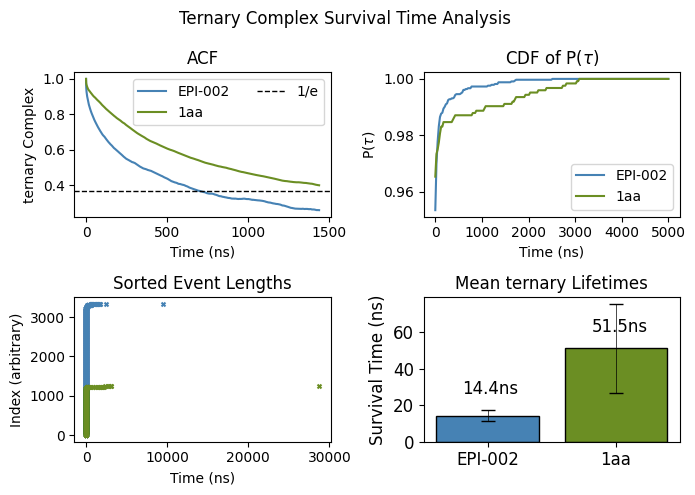

In [273]:
fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.flat
ax = axes
average_ternary = []
tau=[]
longest_ternary_event = []
lengths = []
for path, color, label in zip(paths[1:],
                              [ 'steelblue', 'olivedrab'],
                             labels[1:]):
    
    # any residue - residue CA atom distance less than 1 nm 
    ternary = prod([i.any(1) for i in split(to_contacts(np.load(f'{path}/ligand_distances.npy'), 0.6))])


    #event lengths scaled
    lengths = 0.24 * np.fromiter(map(len, contiguous_bool(bools=ternary)), float)

    #bootstrap mean
    average_ternary.append(list(bootstrap(lengths, n_resamples=5000)))

    
    longest_ternary_event.append(get_longest_event(ternary))
    # have to bootstrap the lengths because it's not a time continuous measurement (block error doesn't make sense here)
    # inverse FFT for the ACF on binary array
    ac = acf(ternary)
    #get the correlation time
    tau.append(get_tau(ac))
    axes[0].plot(np.arange(0, 6000) * 0.24,  # scale the time
                 ac[:6000],
                 c=color,
                 label=label,
                )
    bins=200
    axes[1].plot( np.linspace(0, 5000, bins), np.cumsum(pmf(np.sort(lengths), bins=bins, range=(0,5000))[0]), label=label, c=color)
    axes[2].scatter(np.sort(lengths), np.arange(len(lengths)), label=label, c=color, s=8, marker='x')
    #box_plot(pmf(np.sort(lengths), bins=4, range=(0,30000), norm=False)[0], label=label, ax=axes[2])



axes[2].set_xlabel('Time (ns)')
axes[2].set_ylabel('Index (arbitrary)')
axes[2].set_title('Sorted Event Lengths')

axes[1].set_ylabel(r'P($\tau$)')
axes[1].set_xlabel('Time (ns)')
axes[1].legend()
axes[1].set_title('CDF of ' + r'P($\tau$)')

axes[0].axhline(y=1/np.exp(1),
                linestyle='--',
                color='black',
                linewidth=1,
                label='1/e',
               )

axes[0].set_xlabel(r"Time (ns)")
axes[0].set_ylabel("ternary Complex")
axes[0].legend(ncol=2)
axes[0].set_title('ACF')

#axes[2].legend()
fig.suptitle('Ternary Complex Survival Time Analysis')




box_plot(np.fromiter((i[0] for i in average_ternary), float),
         errors=np.array([[abs(j - i[0]) for j in i[1]] for i in average_ternary]).T,
         error_capsize=5,
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['steelblue', 'olivedrab'],
         alpha=1, 
         font_scale=2, 
         labels=labels[1:],
         title = 'Mean ternary Lifetimes',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         width=0.8,
         ax=ax[3])

ax[3].set_ylabel("Survival Time (ns)")

ax[3].text(-.2, 26, f'{average_ternary[0][0] :.1f}ns', size=12)
ax[3].text(.81, 60, f'{average_ternary[1][0] :.1f}ns',size=12)
#ax[3].text(1.6, 144, f'{average_[2][0] :.1f}ns')
fig.tight_layout()

# Longest Event Analysis

9
10
7
9
10


Text(0.5, 1.1, 'Decomposition of the Longest Dimer Complex by Writhe States')

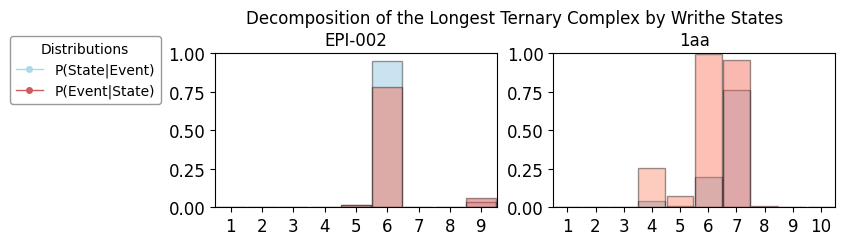

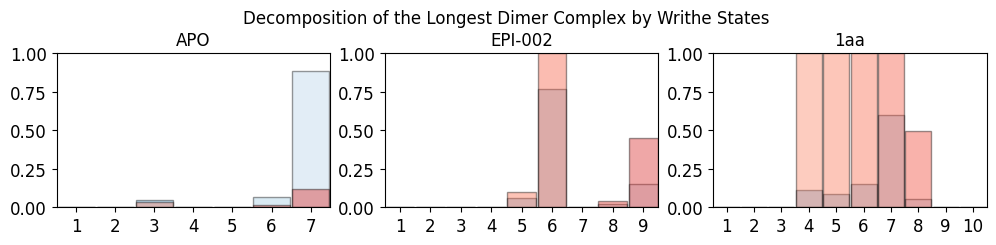

In [323]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
for i, (ax, frames, dtraj, label) in enumerate(zip(axes.flat, longest_ternary_event, dtrajs[1:], labels[1:])):
    print(np.unique(dtraj).size)
    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1, title = label,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
           bbox_to_anchor = [-.14,1])

fig.suptitle("Decomposition of the Longest Ternary Complex by Writhe States", y=1.1)


fig, axes = plt.subplots(1, 3, figsize=(12, 2))
for i, (ax, frames, dtraj, label) in enumerate(zip(axes.flat, longest_dimer_event, dtrajs, labels)):
    print(np.unique(dtraj).size)
    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1, title = label,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
# fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
#            fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
#            bbox_to_anchor = [.9,1])

fig.suptitle("Decomposition of the Longest Dimer Complex by Writhe States", y=1.1)

 # return back to the tCCA state decompositions to see analysis of the longest lived dimer and ternary complexes

# Writhe tCCA Latent Space Analysis

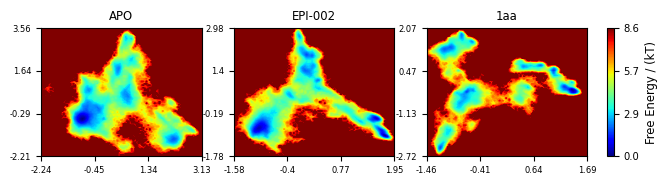

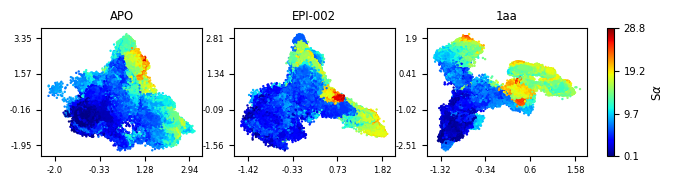

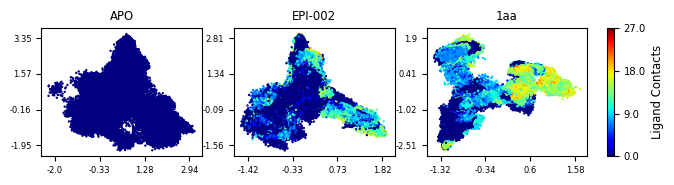

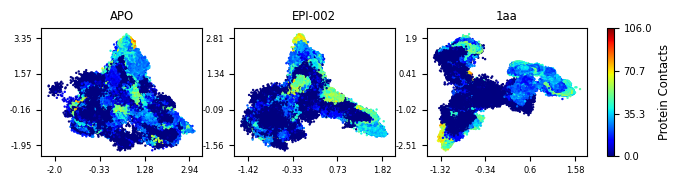

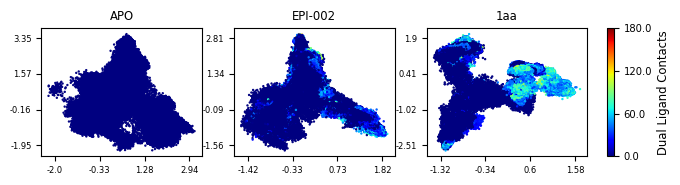

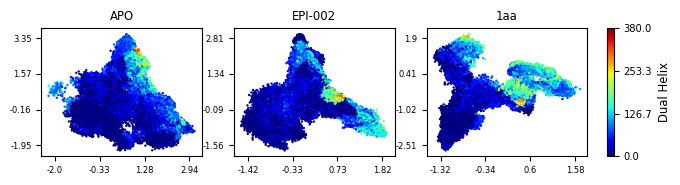

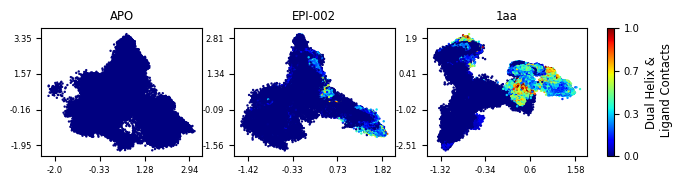

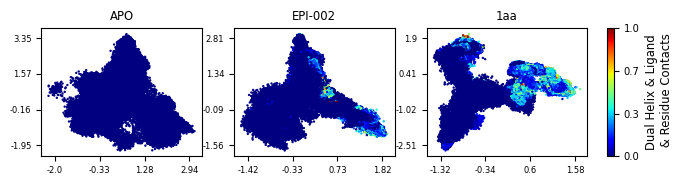

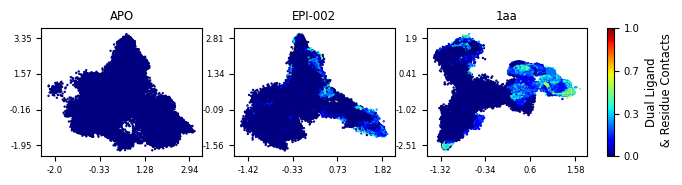

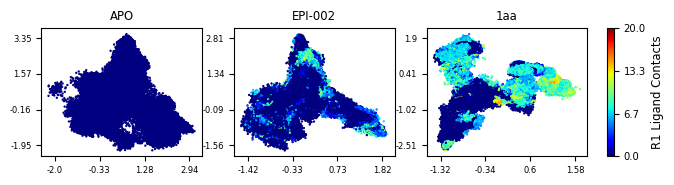

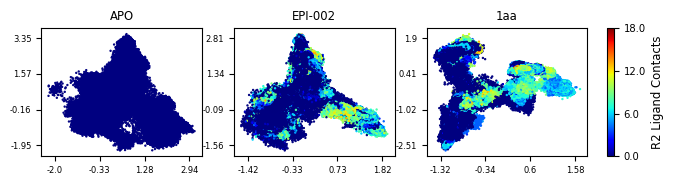

In [103]:

dot_size = 0.0001



subplots_fes2d([i[:, :2] for i in projs], 1, 3, labels, figsize=(7.2, 2), share_extent=False)

subplots_proj2d([i[1:, :2] for i in projs],
                [np.load(f'{path}/r1r2_sa.npy').sum(-1) for path in paths],
                1, 3, labels,
                figsize=(7.2, 2 ),
                share_edef bootstrap(data: np.ndarray,
              confidence_level: float = 0.95,
              n_resamples: int = 500,
              method: str = "percentile") -> Tuple[float, float]:
    """
    Bootstrap binary data to get the mean and an intentionally wide error estimate.

    Parameters:
        data: binary array of 0s and 1s
        confidence_level: typically 0.99 for wider intervals
        n_resamples: lower values increase variability (default 500)
        method: use 'percentile' to produce wider CIs

    Returns:
        mean: estimated mean of the binary array
        error: half-width of the confidence interval
    """

    res = scipy.stats.bootstrap((data,), statistic=np.mean,
                    confidence_level=confidence_level,
                    n_resamples=n_resamples,
                    method=method,
                    random_state=0)

    mean = np.mean(data)
    error = (res.confidence_interval.low, res.confidence_interval.high, ) 
    return [mean, error]xtent=False,
                dot_size=dot_size,
                cbar_label= r"S$\alpha$")


subplots_proj2d([i[1:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Ligand Contacts",
)

subplots_proj2d([i[1:, :2] for i in projs],
                [ResidueDistances.load(path).contacts(.6).sum(-1)
                 for path in r1r2_distance_paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Protein Contacts")

subplots_proj2d([i[1:, :2] for i in projs],
                [product(split(to_contacts(np.load(f'{path}/ligand_distances.npy'))), sum_=True)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Dual Ligand Contacts",
)



subplots_proj2d([i[1:, :2] for i in projs],
                [product(split(np.load(f'{path}/dsspH.npy')), sum_=True) for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=70,
                cbar_label= "Dual Helix",
)

from itertools import chain
subplots_proj2d([i[1:, :2] for i in projs],
                ligand_helix,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=70,
                cbar_label= "Dual Helix &\n Ligand Contacts",
)

subplots_proj2d([i[1:, :2] for i in projs],
                protein_ligand_helix,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=0.6,
                cbar_label= "Dual Helix & Ligand\n & Residue Contacts",
)

subplots_proj2d([i[1:, :2] for i in projs],
                protein_ligand,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=0.6,
                cbar_label= "Dual Ligand\n & Residue Contacts",
)



subplots_proj2d([i[1:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')[:, :24]).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "R1 Ligand Contacts")

subplots_proj2d([i[1:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')[:, 24:]).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "R2 Ligand Contacts")


In [375]:
dtrajs = [Kmeans(i, n, d)[0] for i, d, n  in zip(projs, (5, 3, 5), (45, 80, 45))]

In [445]:
dtrajs[1] = Kmeans(projs[1], 120, 7)[0]

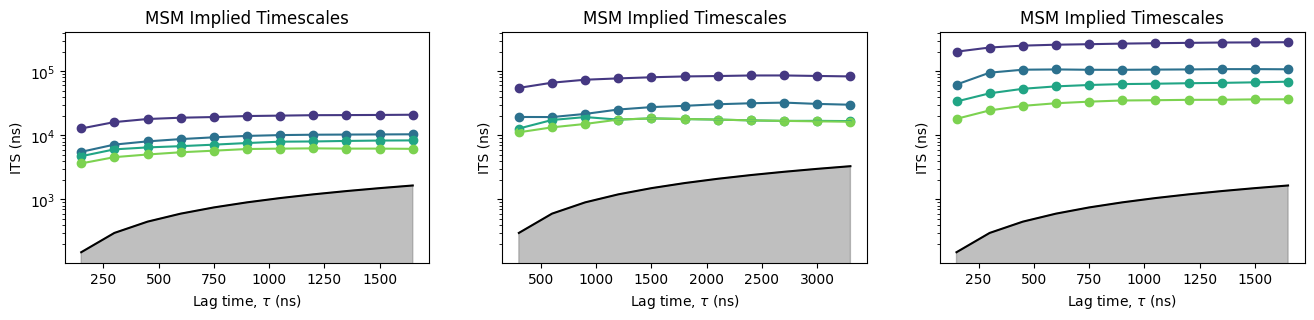

In [447]:
msms = [MarkovModel(i).estimate_msm(lag, 10, reversible=False) for i, lag in zip(dtrajs, (150, 300, 150))]
fig, axes = plt.subplots(1, 3, figsize=(16, 3), sharey=True)
for model, ax, label in zip(msms, axes.flat, labels):
    model.its('msm', ax=ax, n_its=4)